We will begin by importing the requisite libraries for training our timeseries model and then reading in our dataset.

In [405]:
# import libraries for time series modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.var import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pmd

In [341]:
# read in data frame
sf_dev_projs = pd.read_csv('./data/five_yr_pipeline.csv', low_memory = False)

In [342]:
# displays the head of the data frame
sf_dev_projs.head()

,landuse,nameaddr,entitled,beststat,bestdate,units,tcocfcdate,tcocfcunits,unitsnet,pipelineunits,...,heightbul,pda,longitude,latitude,year,qtr,yearqtr,latlong,currentpolicedistricts,affordable
0,Resident,836 48TH AV,1,CONSTRUCTION,09/20/2021 11:44:06 AM,2.0,None applied,0.0,1.0,1.0,...,40-X,Richmond Corridors,-122.508817,37.772600,2022.0,Q4,2022_Q4,POINT (-122.5088171 37.7725997),8.0,0.0
1,Vacant,735 BRYANT ST,1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,None applied,0.0,0.0,0.0,...,270-CS,Eastern Neighborhoods,-122.400848,37.776946,2022.0,Q4,2022_Q4,POINT (-122.400848374 37.7769458793),1.0,0.0
2,Resident,2626 GRIFFITH ST,1,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,Bayview/Southeast Neighborhoods,-122.388080,37.718621,2022.0,Q4,2022_Q4,POINT (-122.388080214 37.7186214874),2.0,0.0
3,Resident,49 SUSSEX ST,1,BP APPROVED,12/13/2019 09:43:07 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,J Church and Mission Corridor,-122.433855,37.736508,2022.0,Q4,2022_Q4,POINT (-122.433855046 37.7365078557),9.0,0.0
4,Resident,1247 BOSWORTH ST,1,BP ISSUED,08/10/2022 12:00:00 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,0,-122.441421,37.735635,2022.0,Q4,2022_Q4,POINT (-122.441420855 37.7356345978),9.0,0.0


Although we used many more features in our clustering models, for the timeseries models we should only need the "beststat" and "bestdate" for charting the progress of where a project is in the development pipeline over time and our focal variables of net units and net affordable units. We shall also pull the year and quarter data for assigning ongoing projects to particular quarters in time.

In [343]:
# creates a copy of the data frame with the subset of columns required for the timeseries models
dev_projs_time = sf_dev_projs[['beststat', 'bestdate', 'unitsnet', 'affordablenet', 'yearqtr']].copy()

dev_projs_time

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0,2022_Q4
1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0,2022_Q4
2,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0,2022_Q4
3,BP APPROVED,12/13/2019 09:43:07 AM,1.0,0.0,2022_Q4
4,BP ISSUED,08/10/2022 12:00:00 AM,1.0,0.0,2022_Q4
...,...,...,...,...,...
43197,BP FILED,02/09/2017 12:00:00 AM,0.0,0.0,2018_Q1
43198,PL FILED,02/01/2018 12:00:00 AM,3.0,0.0,2018_Q1
43199,PL FILED,03/16/2018 12:00:00 AM,2.0,0.0,2018_Q1
43200,CONSTRUCTION,03/08/2018 12:00:00 AM,0.0,0.0,2018_Q1


Before continuing with our timeseries, we must preprocess our data with a datetime index here. We have two options, one to use the bestdate column and another to use the yearqtr column. Although the bestdate is a more accurate measure of exactly when a project is reported to enter the next phase in a project, it may not be the best in determining how many total projects or total units are extant in a given quarter since projects may stall in a phase of the pipeline for several quarters or perhaps years. However, the bestdate column could give us a more accurate picture of how frequently new construction projects actually break ground on construction of new units. Either way, we begin first by focusing our efforts on the construction phase of these development projects and then compare the timeseries model of the bestdate in comparison to the yearqtr reports and evaluate which is a better measure to predicting future construction of net unit and net affordable units.

We shall begin by masking for only construction best stat and making two copies of the data frame, one in which the oldest bestdate is the index and another in which the yearqtr is the index.

In [344]:
# make a copy of the data frame with only the construction status
constr = dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].copy()

constr

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0,2022_Q4
1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0,2022_Q4
2,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0,2022_Q4
5,CONSTRUCTION,10/07/2019 12:00:00 AM,1.0,0.0,2022_Q4
8,CONSTRUCTION,10/09/2019 12:00:00 AM,1.0,0.0,2022_Q4
...,...,...,...,...,...
43162,CONSTRUCTION,02/02/2018 12:00:00 AM,0.0,0.0,2018_Q1
43167,CONSTRUCTION,04/04/2018 12:00:00 AM,0.0,0.0,2018_Q1
43179,CONSTRUCTION,01/04/2018 12:00:00 AM,0.0,0.0,2018_Q1
43186,CONSTRUCTION,12/14/2017 12:00:00 AM,0.0,0.0,2018_Q1


In [345]:
# convert bestdate dates to datetime
constr['bestdate'] = pd.to_datetime(constr['bestdate'], format = 'mixed')

In [346]:
# shows value counts of yearqtr, including nulls
constr['yearqtr'].value_counts(dropna = False)

yearqtr
2022_Q2    544
2022_Q3    533
2022_Q4    511
2021_Q2    469
2021_Q3    427
2020_Q1    427
2019_Q4    413
2019_Q3    406
2022_Q1    398
2021_Q4    395
NaN        389
2020_Q2    388
2019_Q1    354
2018_Q4    339
2020_Q3    336
2018_Q3    329
2018_Q2    326
2020_Q4    306
2018_Q1    291
2021_Q1    254
Name: count, dtype: int64

Looking at the value counts, we can see that there is only one quarter missing, 2019 quarter 2, and the total nulls resemble the total number of nulls in other quarterly reports, so we can impute that these nulls are likely missing from that quarter exclusively.

In [347]:
# fill nulls with 2019_Q2
constr['yearqtr'].fillna('2019_Q2', inplace = True)

In [348]:
# check value counts to verify nulls have been imputed
constr['yearqtr'].value_counts(dropna = False)

yearqtr
2022_Q2    544
2022_Q3    533
2022_Q4    511
2021_Q2    469
2021_Q3    427
2020_Q1    427
2019_Q4    413
2019_Q3    406
2022_Q1    398
2021_Q4    395
2019_Q2    389
2020_Q2    388
2019_Q1    354
2018_Q4    339
2020_Q3    336
2018_Q3    329
2018_Q2    326
2020_Q4    306
2018_Q1    291
2021_Q1    254
Name: count, dtype: int64

In [349]:
# map a date to each quarter
constr['yearqtr'] = constr['yearqtr'].map({'2018_Q1': '03/31/2018',
                                           '2018_Q2': '06/30/2018',
                                           '2018_Q3': '09/30/2018',
                                           '2018_Q4': '12/31/2018',
                                           '2019_Q1': '03/31/2019',
                                           '2019_Q2': '06/30/2019',
                                           '2019_Q3': '09/30/2019',
                                           '2019_Q4': '12/31/2019',
                                           '2020_Q1': '03/31/2020',
                                           '2020_Q2': '06/30/2020',
                                           '2020_Q3': '09/30/2020',
                                           '2020_Q4': '12/31/2020',
                                           '2021_Q1': '03/31/2021',
                                           '2021_Q2': '06/30/2021',
                                           '2021_Q3': '09/30/2021',
                                           '2021_Q4': '12/31/2021',
                                           '2022_Q1': '03/31/2022',
                                           '2022_Q2': '06/30/2022',
                                           '2022_Q3': '09/30/2022',
                                           '2022_Q4': '12/31/2022'
                                          })

In [350]:
# convert yearqtr dates to datetime
constr['yearqtr'] = pd.to_datetime(constr['yearqtr'])

In [351]:
# check data types
constr.dtypes

beststat                 object
bestdate         datetime64[ns]
unitsnet                float64
affordablenet           float64
yearqtr          datetime64[ns]
dtype: object

We now have a data frame with the two relevant dates in a datetime format. We shall begin first with making the bestdate our index and then modeling our timeseries using this index for both net units and affordable units. This timeseries model ought to be a better predictor of when new construction begins as opposed to our quarterly index which will be a better predictor for how many units are in the construction pipeline in a given quarter.

We shall start by dropping any duplicates to get the first chronologically occurring instance of the bestdate for new construction and then resetting and sorting our index. Also for the sake of comparison for when we look at quarterly data, we shall look only at 2018-2022, even though there will certainly be new construction in this dataset dating to years prior to 2018.

In [352]:
# make a date frame for preprocessing with bestdate index
constr_bestdate = constr.copy()

In [353]:
# drop duplicates to get only the first occurring instance of a bestdate
constr_bestdate = constr_bestdate.drop_duplicates(subset = 'bestdate')

constr_bestdate

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,2021-09-20 11:44:06,1.0,0.0,2022-12-31
1,CONSTRUCTION,2019-07-26 00:00:00,0.0,0.0,2022-12-31
2,CONSTRUCTION,2021-10-20 11:10:35,1.0,0.0,2022-12-31
5,CONSTRUCTION,2019-10-07 00:00:00,1.0,0.0,2022-12-31
8,CONSTRUCTION,2019-10-09 00:00:00,1.0,0.0,2022-12-31
...,...,...,...,...,...
42850,CONSTRUCTION,2017-03-21 00:00:00,1.0,0.0,2018-03-31
42952,CONSTRUCTION,2017-12-12 00:00:00,1.0,0.0,2018-03-31
42983,CONSTRUCTION,2018-02-05 00:00:00,1.0,0.0,2018-03-31
43004,CONSTRUCTION,2017-08-03 00:00:00,1.0,0.0,2018-03-31


In [354]:
# set index to bestdate
constr_bestdate.set_index('bestdate', inplace = True)

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2021-09-20 11:44:06,CONSTRUCTION,1.0,0.0,2022-12-31
2019-07-26 00:00:00,CONSTRUCTION,0.0,0.0,2022-12-31
2021-10-20 11:10:35,CONSTRUCTION,1.0,0.0,2022-12-31
2019-10-07 00:00:00,CONSTRUCTION,1.0,0.0,2022-12-31
2019-10-09 00:00:00,CONSTRUCTION,1.0,0.0,2022-12-31
...,...,...,...,...
2017-03-21 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31
2017-12-12 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31
2018-02-05 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31


In [355]:
# sort index according to datetime
constr_bestdate.sort_index(inplace = True)

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2007-10-01,CONSTRUCTION,401.0,401.0,2018-06-30
2009-04-09,CONSTRUCTION,0.0,0.0,2020-06-30
2014-02-04,CONSTRUCTION,1.0,0.0,2018-06-30
2014-05-21,CONSTRUCTION,1.0,0.0,2018-06-30
2014-05-27,CONSTRUCTION,41.0,0.0,2022-12-31
...,...,...,...,...
2022-11-30,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-08,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-13,CONSTRUCTION,2.0,0.0,2022-12-31


In [356]:
# index only for the years 2018 through 2022
constr_bestdate = constr_bestdate.loc[(constr_bestdate.index >= '2018-01-01')
                                      & (constr_bestdate.index < '2023-01-01')].copy()

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2018-01-03,CONSTRUCTION,2.0,0.0,2018-03-31
2018-01-04,CONSTRUCTION,0.0,0.0,2018-09-30
2018-01-08,CONSTRUCTION,1.0,0.0,2019-03-31
2018-01-10,CONSTRUCTION,0.0,0.0,2018-09-30
2018-01-11,CONSTRUCTION,2.0,0.0,2018-06-30
...,...,...,...,...
2022-11-23,CONSTRUCTION,1.0,0.0,2022-12-31
2022-11-30,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-08,CONSTRUCTION,1.0,0.0,2022-12-31


In [357]:
# drop the beststat & yearqtr column
constr_bestdate.drop(columns = ['beststat', 'yearqtr'], inplace = True)

constr_bestdate.head()

,unitsnet,affordablenet
bestdate,,
2018-01-03,2.0,0.0
2018-01-04,0.0,0.0
2018-01-08,1.0,0.0
2018-01-10,0.0,0.0
2018-01-11,2.0,0.0


We are now prepared to explore our time series data for new construction and begin fitting multiple models.

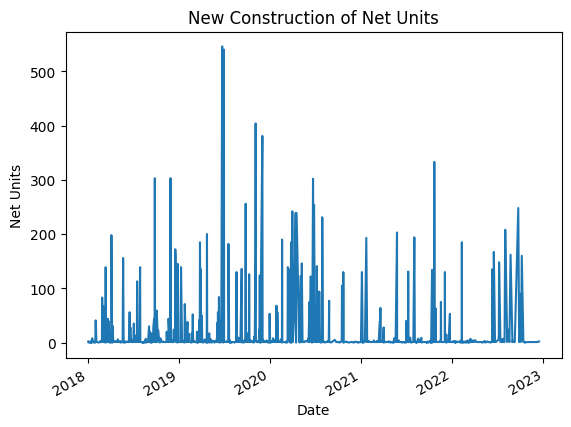

In [358]:
# displays line plot of new construction of net units
constr_bestdate.groupby('bestdate')['unitsnet'].sum().plot(xlabel = 'Date', 
                                                           ylabel = 'Net Units', 
                                                           title = 'New Construction of Net Units');

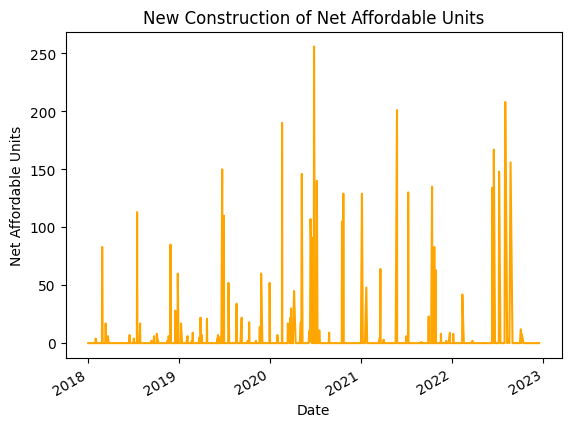

In [359]:
# displays line plot of new construction of net affordable units
constr_bestdate.groupby('bestdate')['affordablenet'].sum().plot(xlabel = 'Date', 
                                                                ylabel = 'Net Affordable Units', 
                                                                title = 'New Construction of Net Affordable Units',
                                                                color = 'orange'
                                                               );

The graphs above show the time series for the new construction of net units and net affordable units for five years. However, both of these graphs appear very jagged and may prove difficult to model without overfitting unless we can smooth the data. First, we will resample our dataset on a monthly basis since there are almost certainly some new projects which break ground every month but not necessarily every week.

In [360]:
# resamples data on a monthly basis
constr_bestdate_monthly = constr_bestdate.resample('M').mean()

constr_bestdate_monthly.head()

,unitsnet,affordablenet
bestdate,,
2018-01-31,1.428571,0.00
2018-02-28,11.250000,7.25
2018-03-31,16.050000,1.15
2018-04-30,12.550000,0.00
2018-05-31,11.600000,0.00


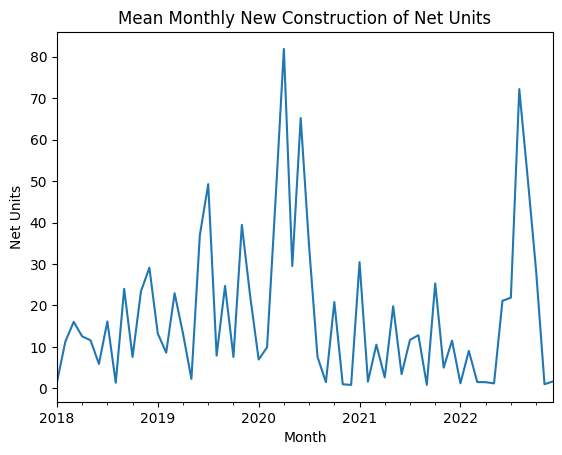

In [361]:
# displays line plot of mean monthly new construction of net units
constr_bestdate_monthly['unitsnet'].plot(xlabel = 'Month', 
                                         ylabel = 'Net Units', 
                                         title = 'Mean Monthly New Construction of Net Units');

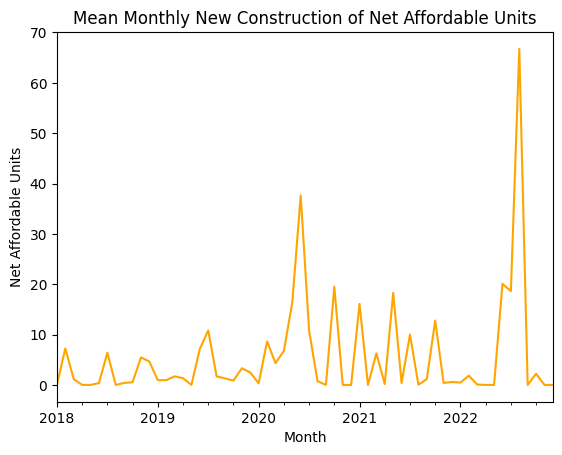

In [362]:
# displays line plot of mean monthly new construction of net affordable units
constr_bestdate_monthly['affordablenet'].plot(xlabel = 'Month', 
                                              ylabel = 'Net Affordable Units', 
                                              title = 'Mean Monthly New Construction of Net Affordable Units',
                                              color = 'orange'
                                             );

We can now see above the graphs of the mean monthly net units and net affordable units under new construction.

Next, we shall look at the autocorrelations and partial autocorrelations to check for seasonanility for modeling purposes. We shall also look at our results from the Augmented Dickey-Fuller Test to surmise how much differencing will make sense as we model moving forward.

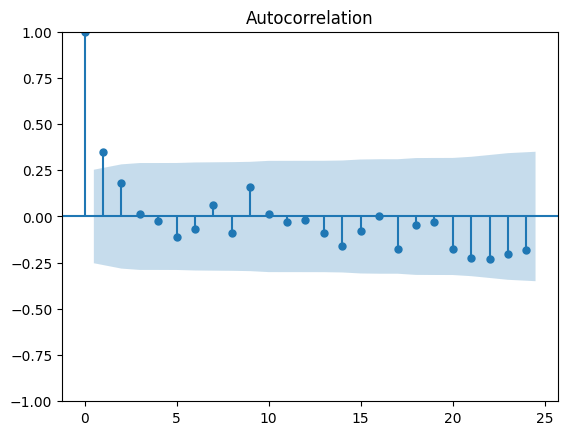

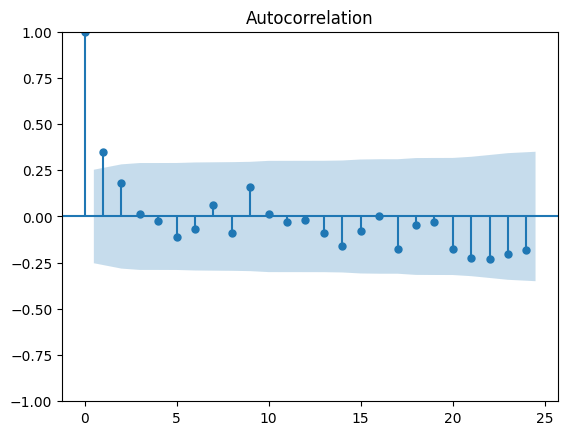

In [363]:
# plots autocorrelation for net units over 24 lag (2 years)
plot_acf(constr_bestdate_monthly['unitsnet'], lags = 24)

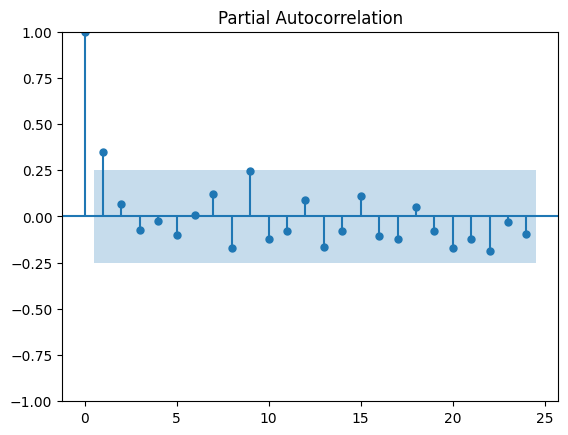

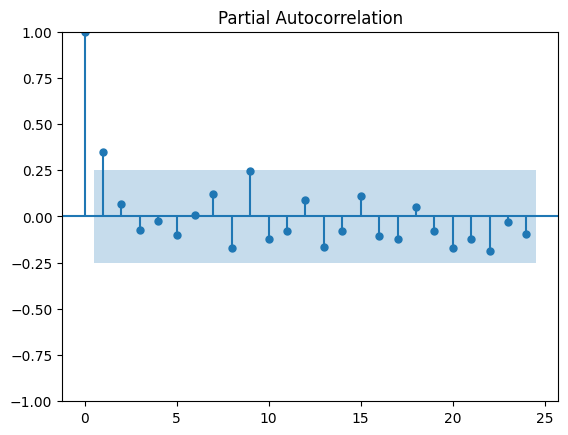

In [364]:
# plots partial autocorrelation for net units over 24 lag (2 years)
plot_pacf(constr_bestdate_monthly['unitsnet'], lags = 24)

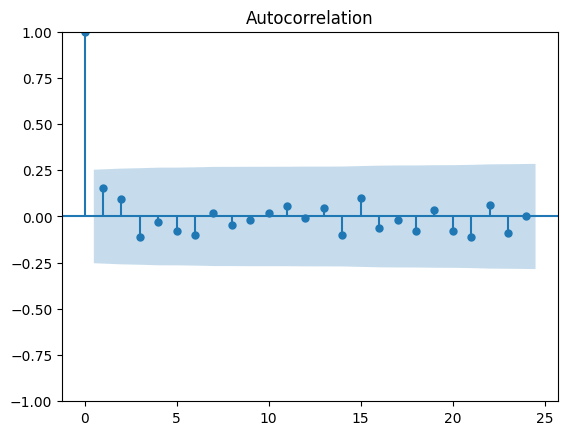

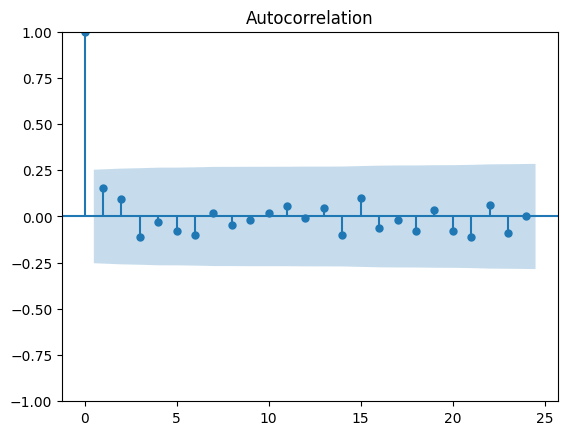

In [365]:
# plots autocorrelation for net affordable units over 24 lag (2 years)
plot_acf(constr_bestdate_monthly['affordablenet'], lags = 24)

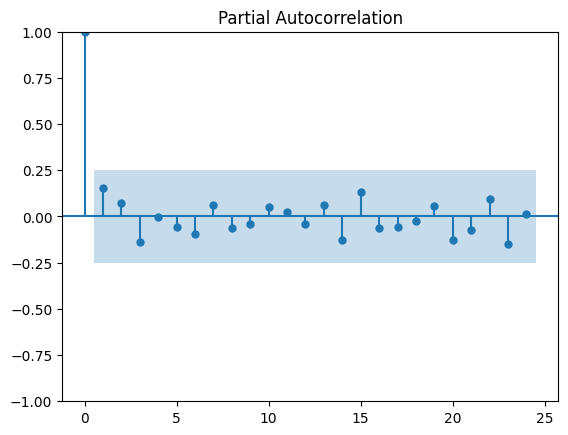

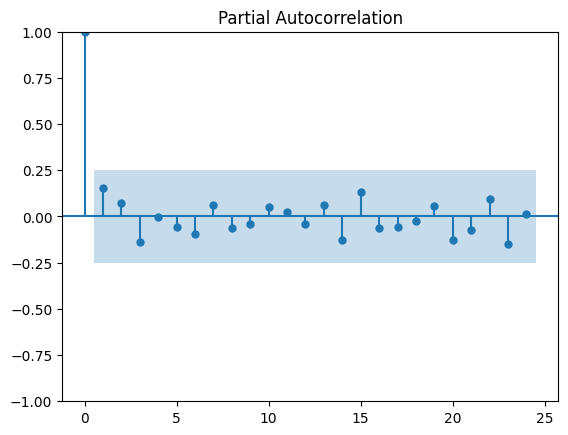

In [366]:
# plots partial autocorrelation for net units over 24 lag (2 years)
plot_pacf(constr_bestdate_monthly['affordablenet'], lags = 24)

Looking at the autocorrelations and partial autocorrelations for the net units, we can see that it appears like there is only a statistically significant autocorrelation at a lag of one month. Even at two months, we don't see a significant autocorrelation. Additionally, there is no clear seasonality in these autocorrelations, indicating no consistent pattern for new construction. Checking the autocorrelation and partial autocorrelation plots for net affordable units there is not even a significant one month lag correlation. This suggests that our subsequent time series models are going to be extremely hard to predict the net units or net affordable units moving forward.

Before moving to our first naive forecast, we shall check the Augmented Dickey-Fuller test for stationarity and determine whether our data are really apt for forecasting in the first place.

In [367]:
# creates a function to return the output of the Dickey-Fuller test
def interpret_dftest(dftest):
    dfoutput = pd.DataFrame(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [368]:
# Run ADF test on the net units
interpret_dftest(adfuller(constr_bestdate_monthly['unitsnet']))

,0
Test Statistic,-5.224083
p-value,0.000008
Lag Used,0.000000


In [369]:
interpret_dftest(adfuller(constr_bestdate_monthly['affordablenet']))

,0
Test Statistic,-6.449181e+00
p-value,1.538679e-08
Lag Used,0.000000e+00


The good news is looking at our Augmented Dickey-Fuller Test we can see that the net units shows a p-value of 0.000008 which is well below the 0.01 threshold we common use to reject the null hypothesis. The same is true for our net affordable units with a p-value of 0.000000015. In both of these cases, we can say with 99% confidence that both of these time series datasets have sufficient stationarity at 0 lags. This will inform our methodology especially when we get to our vector autoregression of both variables at the same time.

We will look at net units first and create and evaluate several time series models to determine which might be the best for predicting future new construction of net units. We shall begin with a train test split and set up a naive forecast.

In [370]:
# create a train test split
train, test = train_test_split(constr_bestdate_monthly[['unitsnet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

In [371]:
# check the train shape
print(train.shape)

(48, 1)


In [372]:
# check the test shape
test.shape

(12, 1)

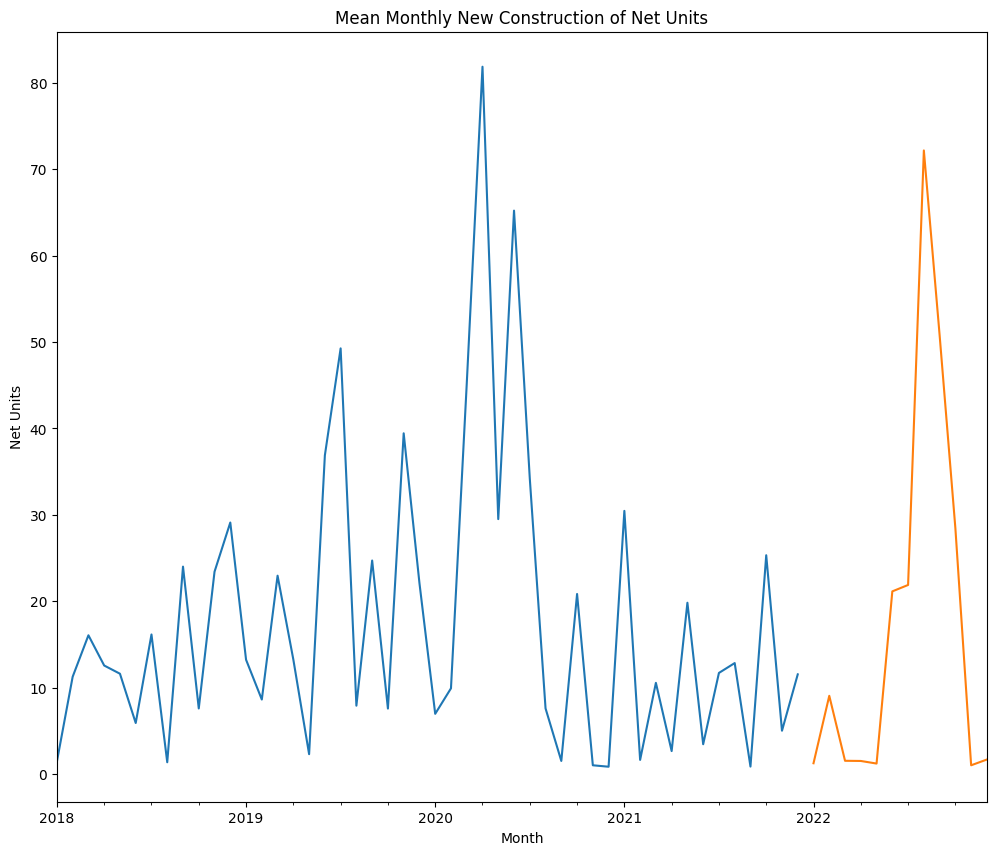

In [373]:
# displays graph of train and test data for net units
train['unitsnet'].plot()
test['unitsnet'].plot(figsize = (12, 10), 
                      xlabel = 'Month',
                      ylabel = 'Net Units',
                      title = 'Mean Monthly New Construction of Net Units');

In [374]:
# creates a prediction data frame which is a copy of the test data
units_preds = test.copy()

units_preds

,unitsnet
bestdate,
2022-01-31,1.235294
2022-02-28,9.043478
2022-03-31,1.520000
2022-04-30,1.500000
2022-05-31,1.200000
2022-06-30,21.133333
2022-07-31,21.875000
2022-08-31,72.181818
2022-09-30,50.800000


In [375]:
# creates a prediction column based on the last value in the train dataset
units_preds['last'] = train['unitsnet'][-1]

units_preds

,unitsnet,last
bestdate,,
2022-01-31,1.235294,11.526316
2022-02-28,9.043478,11.526316
2022-03-31,1.520000,11.526316
2022-04-30,1.500000,11.526316
2022-05-31,1.200000,11.526316
2022-06-30,21.133333,11.526316
2022-07-31,21.875000,11.526316
2022-08-31,72.181818,11.526316
2022-09-30,50.800000,11.526316


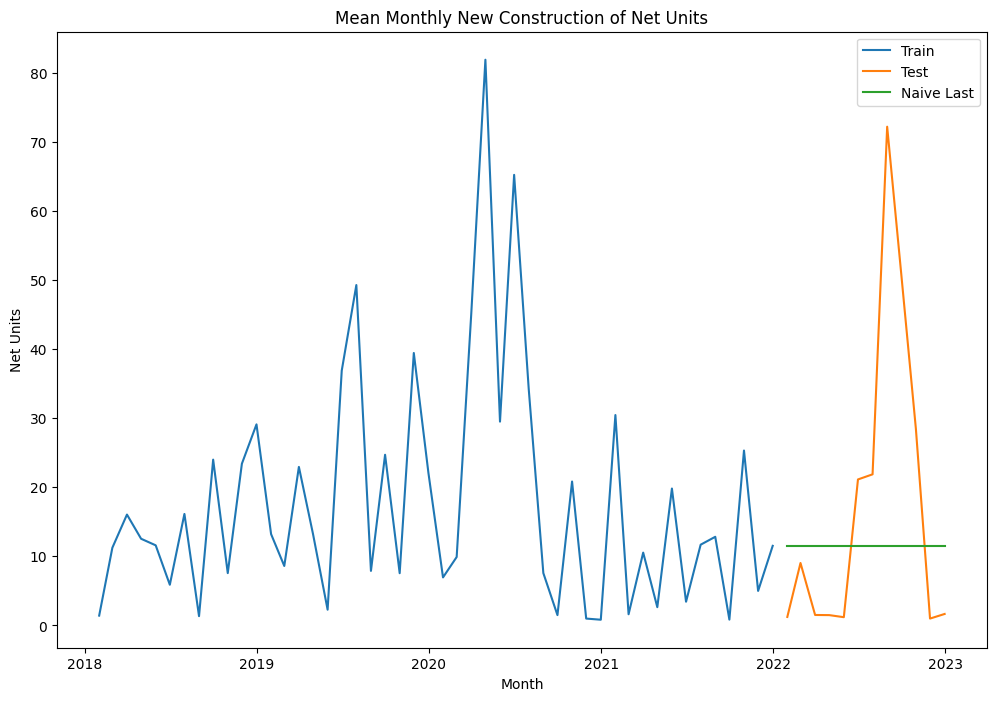

In [400]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['last'], label = 'Naive Last')

plt.xlabel('Month')
plt.ylabel('Net Units')
plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [377]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(units_preds['unitsnet'], units_preds['last'], squared = False)

22.975525286051887

In [378]:
# creates a column the simple mean based on the training historical mean
units_preds['simple_mean'] = train['unitsnet'].mean()

units_preds.head()

,unitsnet,last,simple_mean
bestdate,,,
2022-01-31,1.235294,11.526316,17.683992
2022-02-28,9.043478,11.526316,17.683992
2022-03-31,1.520000,11.526316,17.683992
2022-04-30,1.500000,11.526316,17.683992
2022-05-31,1.200000,11.526316,17.683992


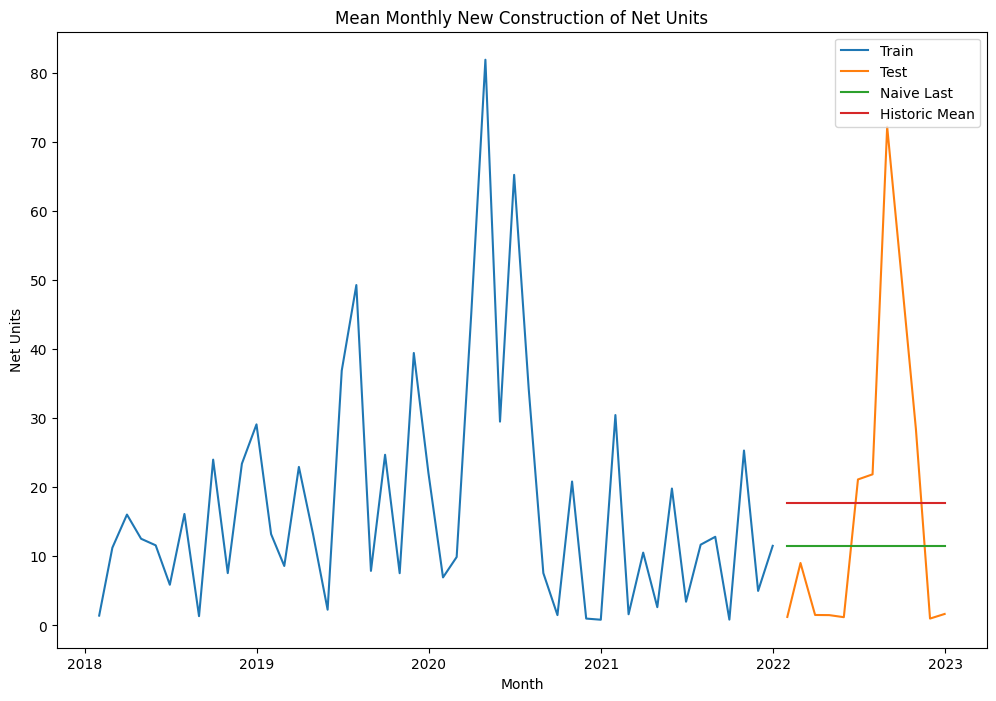

In [401]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['last'], label = 'Naive Last')
plt.plot(units_preds.index, units_preds['simple_mean'], label = 'Historic Mean')

plt.xlabel('Month')
plt.ylabel('Net Units')
plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [380]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['simple_mean'], squared = False)

22.149077390373808

In the cells above we have graphed our train and test data against our naive last prediction and our historical mean. Based on the root mean squared error in both cases, the historical mean performs slightly better with an RSME of ~22.15 than the naive last with an RSME of ~22.98. However, in both cases, we can see that both perform verly poorly, as the naive last prediction is ~11.5 and the historic mean is ~17.7, meaning that the RSME is in the range of negative net units even though there is no month in which the average drops below zero. We will assume for the time being that these data do not have any seasonality based on our partial autocorrelation plots above, so we shall avoid time series models with a seasonality component. We shall first train some exponential smoothing models to assess whether they perform better than our null models.

In [381]:
# fit a simple exponential smoothing model
simexp = SimpleExpSmoothing(train['unitsnet']).fit(smoothing_level = .5, optimized = False)

In [382]:
# shows a summary of the exponential smoothing
simexp.summary()

Dep. Variable:,unitsnet,No. Observations:,48
Model:,SimpleExpSmoothing,SSE,14571.629
Optimized:,False,AIC,278.350
Trend:,None,BIC,282.093
Seasonal:,None,AICC,279.281
Seasonal Periods:,None,Date:,"Fri, 15 Sep 2023"
Box-Cox:,False,Time:,16:34:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,1.4285714,l.0,False


In [383]:
# adds the simple exponential smoothing forecast to the predictions
units_preds['simexp'] = simexp.forecast(len(test))

units_preds

,unitsnet,last,simple_mean,simexp
bestdate,,,,
2022-01-31,1.235294,11.526316,17.683992,10.943972
2022-02-28,9.043478,11.526316,17.683992,10.943972
2022-03-31,1.520000,11.526316,17.683992,10.943972
2022-04-30,1.500000,11.526316,17.683992,10.943972
2022-05-31,1.200000,11.526316,17.683992,10.943972
2022-06-30,21.133333,11.526316,17.683992,10.943972
2022-07-31,21.875000,11.526316,17.683992,10.943972
2022-08-31,72.181818,11.526316,17.683992,10.943972
2022-09-30,50.800000,11.526316,17.683992,10.943972


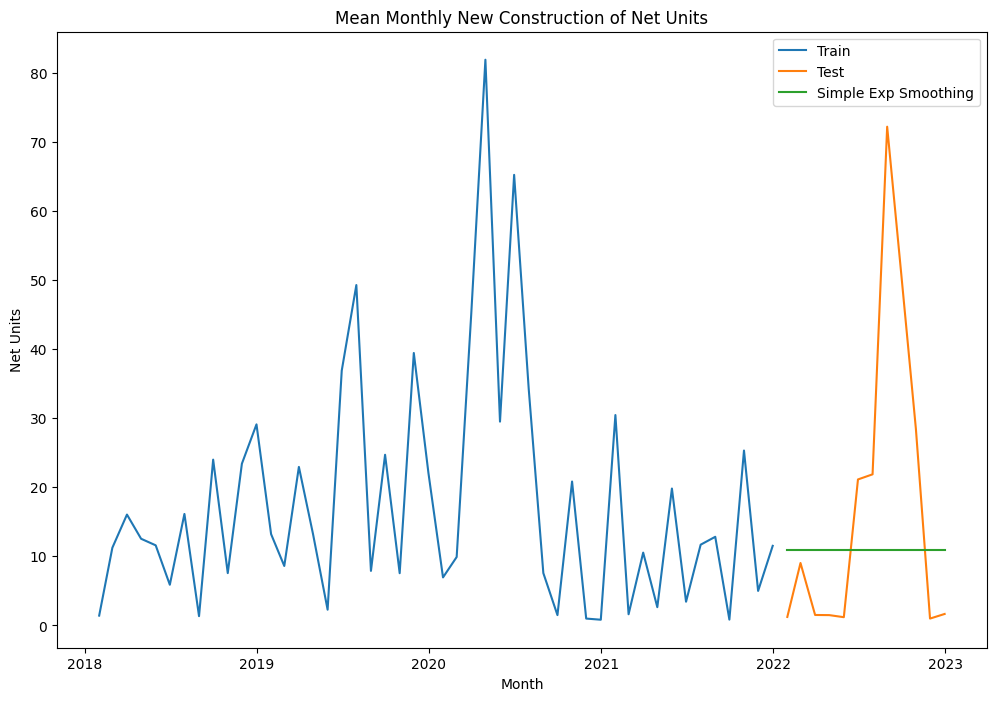

In [402]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['simexp'], label = 'Simple Exp Smoothing')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Net Units');

In [385]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['simexp'], squared = False)

23.137127243229454

In evaluating our simple exponential smoothing model, we can see a root mean squared error of ~23.14 net units which is performing more poorly than both our naive last and historical mean null models. Therefore, the exponential smoothing model is probably not helpful in forecasting our net units. As stated earlier, we have a dataset which does not show any seasonal trends. However, to be sure, we shall attempt a Holt Winters model, using a multiplicative trend since the local minimina and maxima do seem to vary.

In [386]:
# fits a Holt Winters model
hw = ExponentialSmoothing(train['unitsnet'],
                         trend = 'mul').fit()

In [387]:
# shows a summary of Holt Winters data
hw.summary()

Dep. Variable:,unitsnet,No. Observations:,48
Model:,ExponentialSmoothing,SSE,13412.507
Optimized:,True,AIC,278.372
Trend:,Multiplicative,BIC,285.856
Seasonal:,None,AICC,280.420
Seasonal Periods:,None,Date:,"Fri, 15 Sep 2023"
Box-Cox:,False,Time:,16:34:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2240842,alpha,True
smoothing_trend,0.000000,beta,True


In [388]:
# add Holt Winters forecast to prediction data frame
units_preds['hw'] = hw.forecast(len(test))

units_preds

,unitsnet,last,simple_mean,simexp,hw
bestdate,,,,,
2022-01-31,1.235294,11.526316,17.683992,10.943972,10.069621
2022-02-28,9.043478,11.526316,17.683992,10.943972,9.850475
2022-03-31,1.520000,11.526316,17.683992,10.943972,9.636098
2022-04-30,1.500000,11.526316,17.683992,10.943972,9.426387
2022-05-31,1.200000,11.526316,17.683992,10.943972,9.221240
2022-06-30,21.133333,11.526316,17.683992,10.943972,9.020558
2022-07-31,21.875000,11.526316,17.683992,10.943972,8.824243
2022-08-31,72.181818,11.526316,17.683992,10.943972,8.632200
2022-09-30,50.800000,11.526316,17.683992,10.943972,8.444337


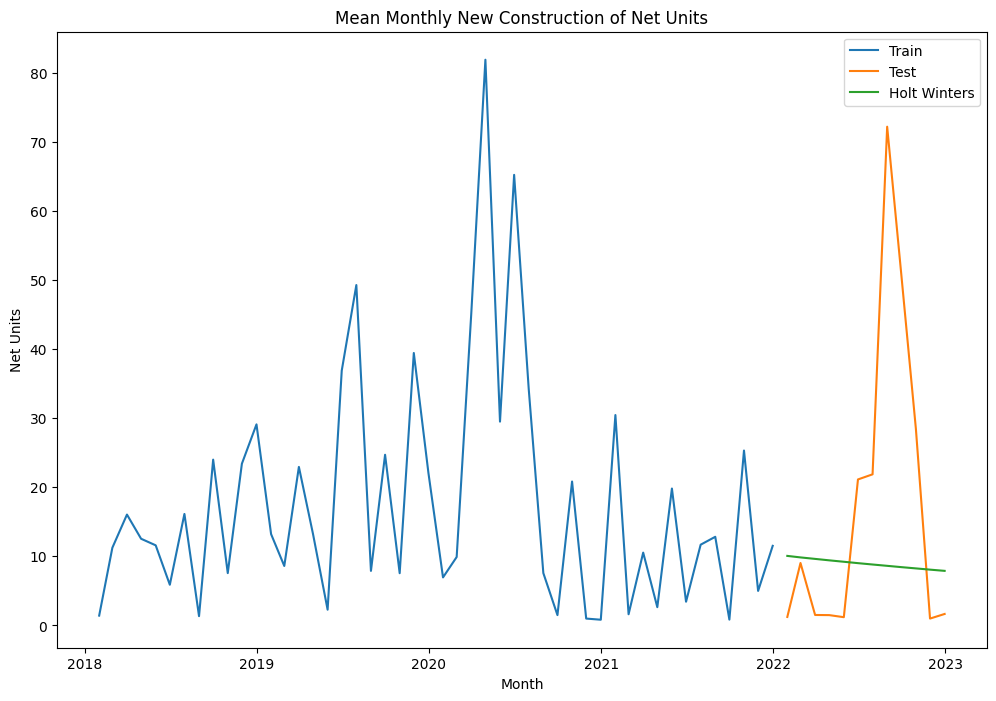

In [403]:
# graphs the train and test data with Holt Winters
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Net Units');

In [390]:
# shows the root mean squared error for Holt Winters
mean_squared_error(units_preds['unitsnet'], units_preds['hw'], squared = False)

24.010025404545605

Looking at the Holt Winters results, we are arriving at an RSME of ~24.01 net units, performing even worse than the simple exponential smoothing model. We can also see this in both summaries above in which the AIC scores on both models is approximately 285, with the Holt Winters slightly higher. This is not surprising because Holt Winters presumes some seasonality, but we saw no evidence of this in our partial autocorrelation. We can say confidently now though that Holt Winters is not a good fit for our time series model.

For our last univariate time series model of these mean monthly net units, we shall fit an ARIMA model, once again checking for any seasonality just in case.

In [392]:
# instantiate
model = pmd.auto_arima(train['unitsnet'], m = 12, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=411.753, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=412.455, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=413.201, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=445.191, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=413.752, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=413.752, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=415.752, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=410.548, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=412.417, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=411.734, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=411.558, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=411.241, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AI

In [192]:
# display model output
model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [395]:
# preview ARIMA predictions
model.predict()

2022-01-31    16.000683
2022-02-28    17.138680
2022-03-31    17.428115
2022-04-30    17.501729
2022-05-31    17.520451
2022-06-30    17.525213
2022-07-31    17.526424
2022-08-31    17.526732
2022-09-30    17.526811
2022-10-31    17.526831
Freq: M, dtype: float64

In [396]:
# add sarima forecast to predictions data frame
units_preds['sarima_auto'] = model.predict(test.shape[0])

In [397]:
# preview prediction data frame
units_preds

,unitsnet,last,simple_mean,simexp,hw,sarima_auto
bestdate,,,,,,
2022-01-31,1.235294,11.526316,17.683992,10.943972,10.069621,16.000683
2022-02-28,9.043478,11.526316,17.683992,10.943972,9.850475,17.138680
2022-03-31,1.520000,11.526316,17.683992,10.943972,9.636098,17.428115
2022-04-30,1.500000,11.526316,17.683992,10.943972,9.426387,17.501729
2022-05-31,1.200000,11.526316,17.683992,10.943972,9.221240,17.520451
2022-06-30,21.133333,11.526316,17.683992,10.943972,9.020558,17.525213
2022-07-31,21.875000,11.526316,17.683992,10.943972,8.824243,17.526424
2022-08-31,72.181818,11.526316,17.683992,10.943972,8.632200,17.526732
2022-09-30,50.800000,11.526316,17.683992,10.943972,8.444337,17.526811


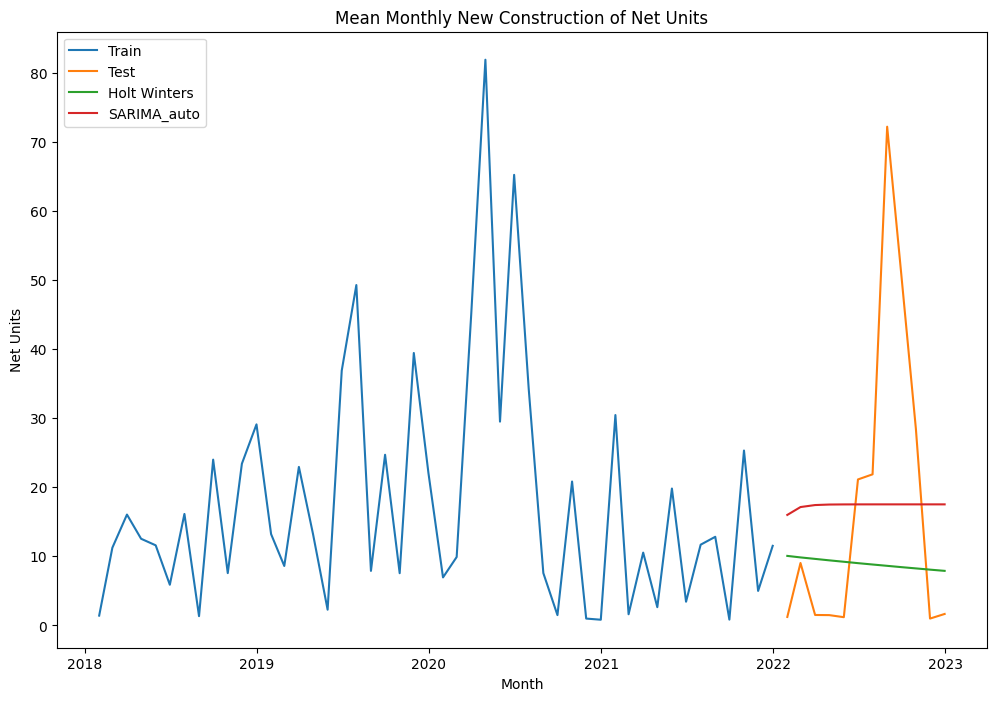

In [404]:
# graphs the train and test data with Holt Winters and SARIMA
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['hw'], label = 'Holt Winters')
plt.plot(units_preds['sarima_auto'], label = 'SARIMA_auto')
plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('Net Units')
plt.title('Mean Monthly New Construction of Net Units');

In [399]:
mean_squared_error(test['unitsnet'], units_preds['sarima_auto'], squared = False)

22.03995865728176

According to the 

In [198]:
# create a train test split
train, test = train_test_split(constr_bestdate_monthly[['affordablenet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

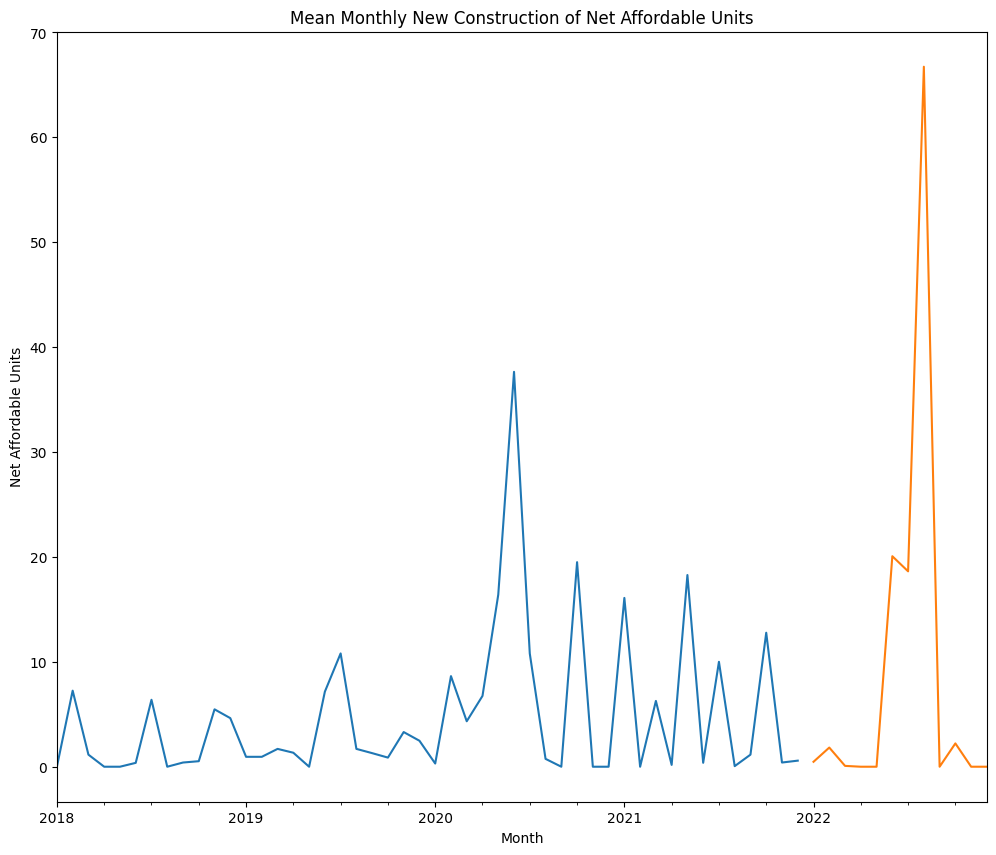

In [199]:
# displays graph of train and test data for net units
train['affordablenet'].plot()
test['affordablenet'].plot(figsize = (12, 10), 
                           xlabel = 'Month',
                           ylabel = 'Net Affordable Units',
                           title = 'Mean Monthly New Construction of Net Affordable Units');

In [200]:
# creates a prediction data frame which is a copy of the test data
affordable_preds = test.copy()

affordable_preds

,affordablenet
bestdate,
2022-01-31,0.470588
2022-02-28,1.826087
2022-03-31,0.080000
2022-04-30,0.000000
2022-05-31,0.000000
2022-06-30,20.066667
2022-07-31,18.625000
2022-08-31,66.727273
2022-09-30,0.000000


In [201]:
# creates a prediction column based on the last value in the train dataset
affordable_preds['last'] = train['affordablenet'][-1]

affordable_preds

,affordablenet,last
bestdate,,
2022-01-31,0.470588,0.578947
2022-02-28,1.826087,0.578947
2022-03-31,0.080000,0.578947
2022-04-30,0.000000,0.578947
2022-05-31,0.000000,0.578947
2022-06-30,20.066667,0.578947
2022-07-31,18.625000,0.578947
2022-08-31,66.727273,0.578947
2022-09-30,0.000000,0.578947


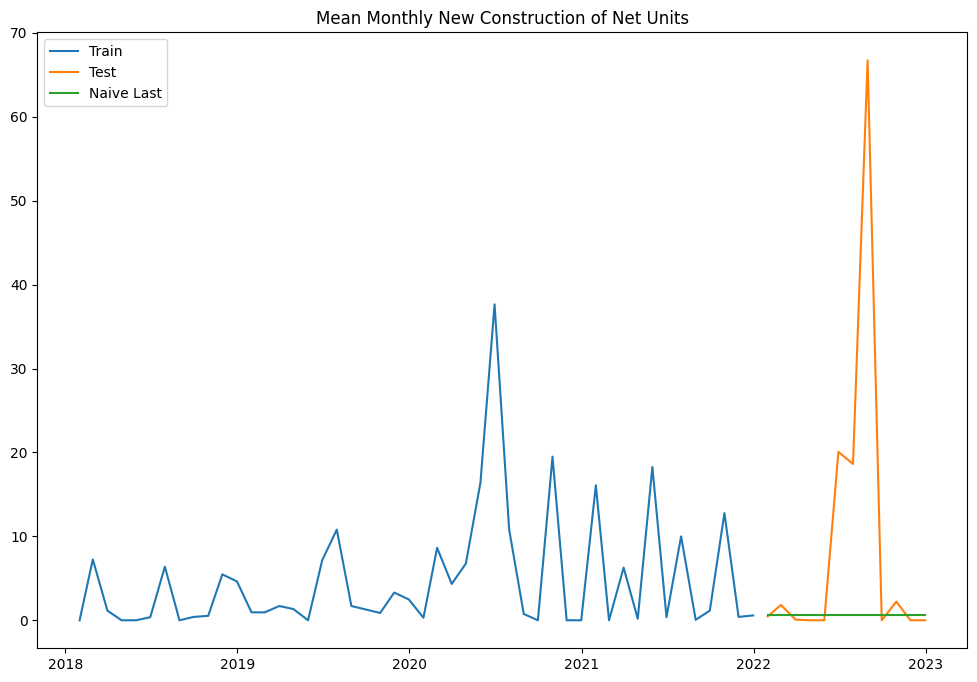

In [202]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(affordable_preds.index, affordable_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [203]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['last'], squared = False)

20.58969092098837

In [204]:
# creates a column the simple mean based on the training historical mean
affordable_preds['simple_mean'] = train['affordablenet'].mean()

affordable_preds.head()

,affordablenet,last,simple_mean
bestdate,,,
2022-01-31,0.470588,0.578947,4.790538
2022-02-28,1.826087,0.578947,4.790538
2022-03-31,0.080000,0.578947,4.790538
2022-04-30,0.000000,0.578947,4.790538
2022-05-31,0.000000,0.578947,4.790538


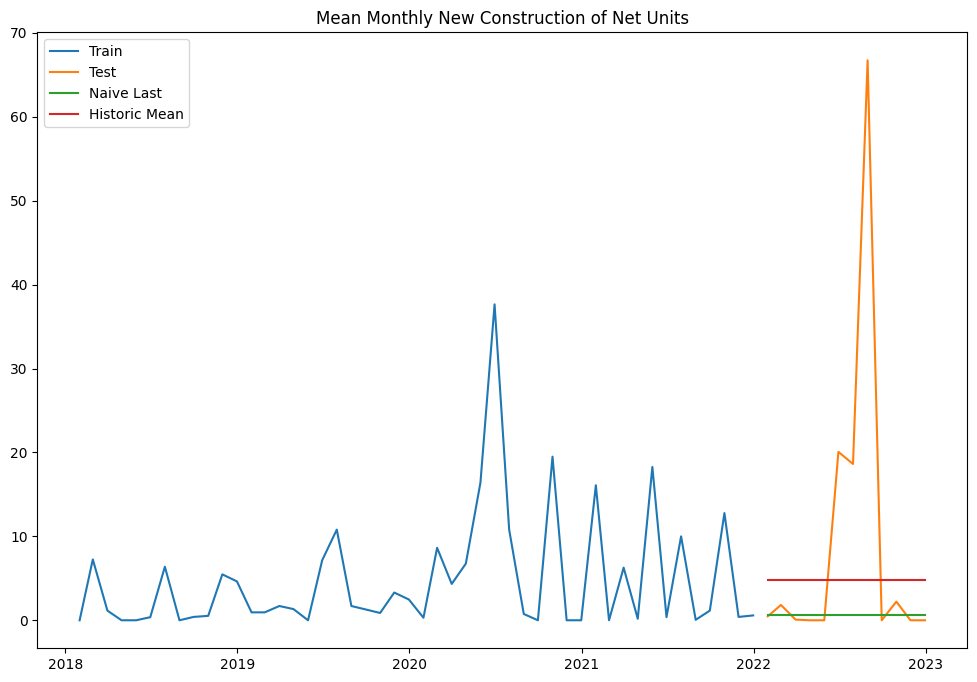

In [205]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(units_preds.index, affordable_preds['last'], label = 'Naive Last')
plt.plot(units_preds.index, affordable_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [206]:
# shows the root mean squared error for the historical mean
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['simple_mean'], squared = False)

19.217815455669886

In [209]:
hw = ExponentialSmoothing(train['affordablenet'],
                         trend = 'add').fit()

In [210]:
hw.summary()

Dep. Variable:,affordablenet,No. Observations:,48
Model:,ExponentialSmoothing,SSE,2336.158
Optimized:,True,AIC,194.483
Trend:,Additive,BIC,201.968
Seasonal:,None,AICC,196.532
Seasonal Periods:,None,Date:,"Fri, 15 Sep 2023"
Box-Cox:,False,Time:,12:35:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.7437e-08,alpha,True
smoothing_trend,1.9997e-10,beta,True


In [211]:
affordable_preds['hw'] = hw.forecast(len(test))

affordable_preds

,affordablenet,last,simple_mean,hw
bestdate,,,,
2022-01-31,0.470588,0.578947,4.790538,7.643000
2022-02-28,1.826087,0.578947,4.790538,7.759428
2022-03-31,0.080000,0.578947,4.790538,7.875855
2022-04-30,0.000000,0.578947,4.790538,7.992282
2022-05-31,0.000000,0.578947,4.790538,8.108709
2022-06-30,20.066667,0.578947,4.790538,8.225136
2022-07-31,18.625000,0.578947,4.790538,8.341563
2022-08-31,66.727273,0.578947,4.790538,8.457990
2022-09-30,0.000000,0.578947,4.790538,8.574418


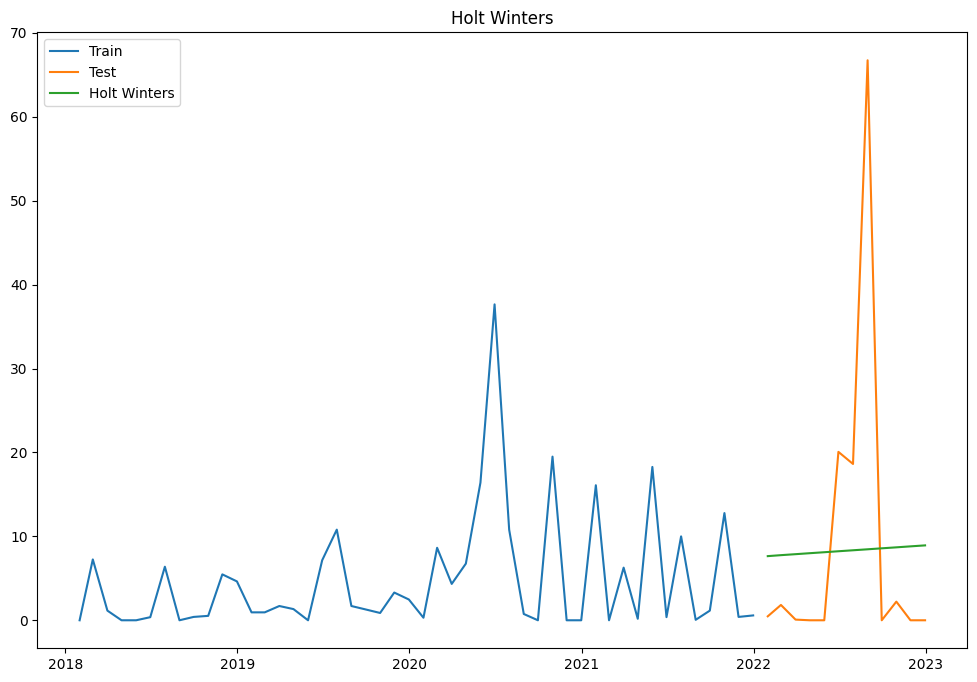

In [212]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(affordable_preds.index, affordable_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.title('Holt Winters');

In [213]:
# shows the root mean squared error for the historical mean
mean_squared_error(affordable_preds['affordablenet'], affordable_preds['hw'], squared = False)

18.687998459207744

In [214]:
model = pmd.auto_arima(train['affordablenet'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=329.201, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=330.558, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=330.548, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=344.956, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=332.548, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.127 seconds


In [215]:
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [216]:
model.predict()

2022-01-31    4.790538
2022-02-28    4.790538
2022-03-31    4.790538
2022-04-30    4.790538
2022-05-31    4.790538
2022-06-30    4.790538
2022-07-31    4.790538
2022-08-31    4.790538
2022-09-30    4.790538
2022-10-31    4.790538
Freq: M, dtype: float64

In [217]:
affordable_preds['sarima_auto'] = model.predict(test.shape[0])

In [218]:
affordable_preds

,affordablenet,last,simple_mean,hw,sarima_auto
bestdate,,,,,
2022-01-31,0.470588,0.578947,4.790538,7.643000,4.790538
2022-02-28,1.826087,0.578947,4.790538,7.759428,4.790538
2022-03-31,0.080000,0.578947,4.790538,7.875855,4.790538
2022-04-30,0.000000,0.578947,4.790538,7.992282,4.790538
2022-05-31,0.000000,0.578947,4.790538,8.108709,4.790538
2022-06-30,20.066667,0.578947,4.790538,8.225136,4.790538
2022-07-31,18.625000,0.578947,4.790538,8.341563,4.790538
2022-08-31,66.727273,0.578947,4.790538,8.457990,4.790538
2022-09-30,0.000000,0.578947,4.790538,8.574418,4.790538


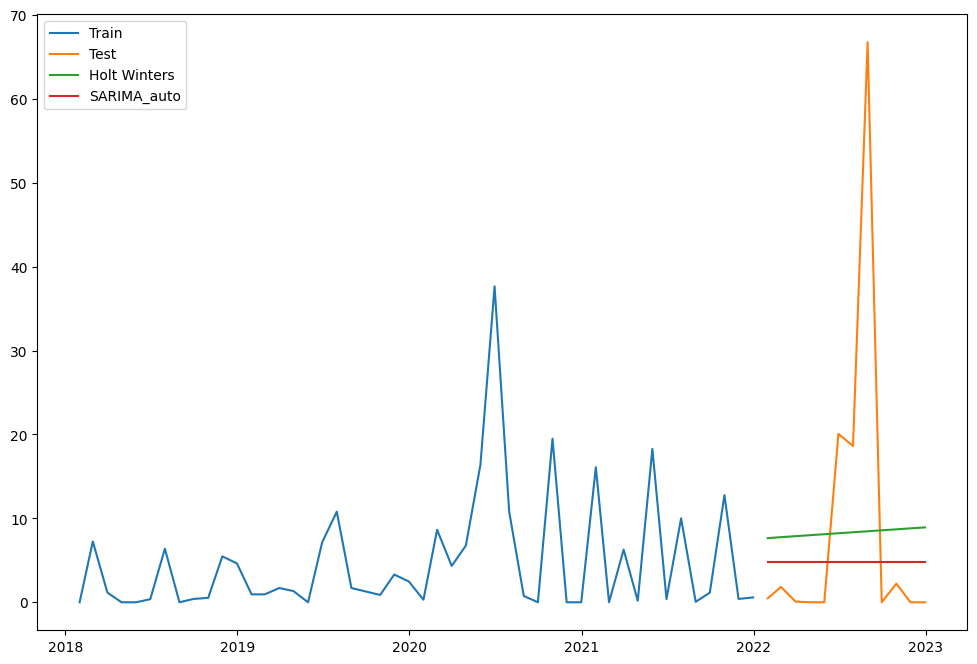

In [219]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(affordable_preds.index, affordable_preds['hw'], label = 'Holt Winters')
plt.plot(affordable_preds['sarima_auto'], label = 'SARIMA_auto')
plt.legend(loc = 'best');

In [220]:
mean_squared_error(test['affordablenet'], affordable_preds['sarima_auto'], squared = False )

19.217815455669886

In [236]:
# make a date frame for preprocessing with bestdate index
constr_qtr = constr.copy()

In [237]:
# set index to bestdate
constr_qtr.set_index('yearqtr', inplace = True)

constr_qtr

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2022-12-31,CONSTRUCTION,2021-09-20 11:44:06,1.0,0.0
2022-12-31,CONSTRUCTION,2019-07-26 00:00:00,0.0,0.0
2022-12-31,CONSTRUCTION,2021-10-20 11:10:35,1.0,0.0
2022-12-31,CONSTRUCTION,2019-10-07 00:00:00,1.0,0.0
2022-12-31,CONSTRUCTION,2019-10-09 00:00:00,1.0,0.0
...,...,...,...,...
2018-03-31,CONSTRUCTION,2018-02-02 00:00:00,0.0,0.0
2018-03-31,CONSTRUCTION,2018-04-04 00:00:00,0.0,0.0
2018-03-31,CONSTRUCTION,2018-01-04 00:00:00,0.0,0.0


In [238]:
# sort index according to datetime
constr_qtr.sort_index(inplace = True)

constr_qtr

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2018-03-31,CONSTRUCTION,2018-03-08 00:00:00,0.0,0.0
2018-03-31,CONSTRUCTION,2018-03-20 00:00:00,3.0,0.0
2018-03-31,CONSTRUCTION,2018-04-13 00:00:00,1.0,0.0
2018-03-31,CONSTRUCTION,2018-02-09 00:00:00,2.0,0.0
2018-03-31,CONSTRUCTION,2018-03-30 00:00:00,3.0,0.0
...,...,...,...,...
2022-12-31,CONSTRUCTION,2020-04-02 00:00:00,1.0,0.0
2022-12-31,CONSTRUCTION,2022-06-02 08:26:15,0.0,0.0
2022-12-31,CONSTRUCTION,2022-01-03 00:00:00,1.0,0.0


In [239]:
constr_qtr.drop(columns = ['bestdate', 'beststat'], inplace = True)

In [240]:
constr_qtr

,unitsnet,affordablenet
yearqtr,,
2018-03-31,0.0,0.0
2018-03-31,3.0,0.0
2018-03-31,1.0,0.0
2018-03-31,2.0,0.0
2018-03-31,3.0,0.0
...,...,...
2022-12-31,1.0,0.0
2022-12-31,0.0,0.0
2022-12-31,1.0,0.0


In [241]:
constr_qtr.groupby('yearqtr')[['unitsnet', 'affordablenet']].sum()

,unitsnet,affordablenet
yearqtr,,
2018-03-31,6748.0,1653.0
2018-06-30,7078.0,2330.0
2018-09-30,7460.0,2267.0
2018-12-31,8073.0,2184.0
2019-03-31,8500.0,2153.0
2019-06-30,9894.0,2875.0
2019-09-30,9430.0,1791.0
2019-12-31,10198.0,2411.0
2020-03-31,9632.0,2230.0


In [242]:
# resamples data on a monthly basis
constr_qtr = constr_qtr.resample('Q').sum()

constr_qtr.head()

,unitsnet,affordablenet
yearqtr,,
2018-03-31,6748.0,1653.0
2018-06-30,7078.0,2330.0
2018-09-30,7460.0,2267.0
2018-12-31,8073.0,2184.0
2019-03-31,8500.0,2153.0


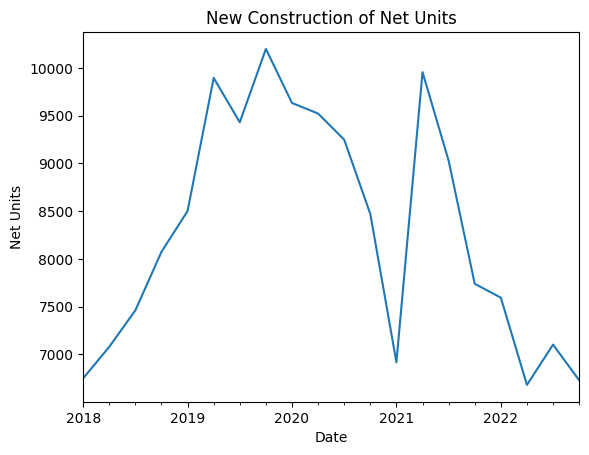

In [243]:
# displays line plot of new construction of net units
constr_qtr['unitsnet'].plot(xlabel = 'Date', 
                            ylabel = 'Net Units', 
                            title = 'New Construction of Net Units');

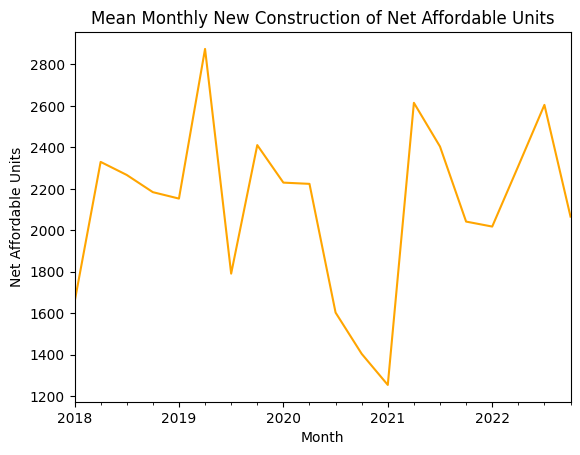

In [244]:
# displays line plot of mean monthly new construction of net affordable units
constr_qtr['affordablenet'].plot(xlabel = 'Month', 
                                              ylabel = 'Net Affordable Units', 
                                              title = 'Mean Monthly New Construction of Net Affordable Units',
                                              color = 'orange'
                                             );

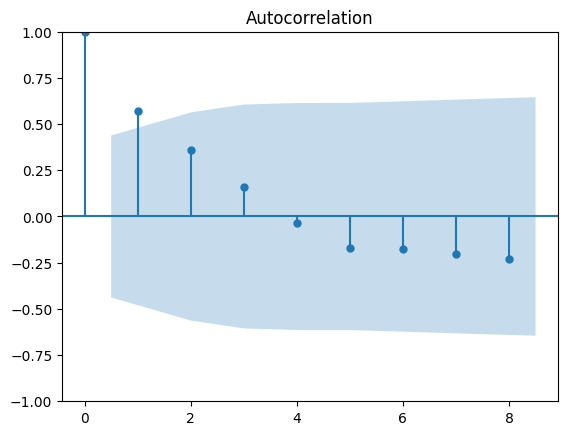

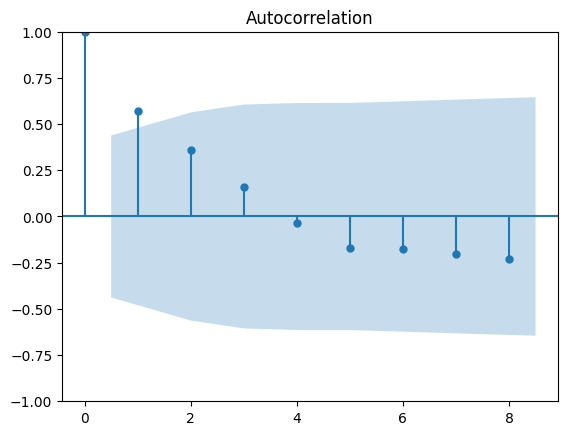

In [249]:
# plots autocorrelation for net units over 24 lag (2 years)
plot_acf(constr_qtr['unitsnet'], lags = 8)

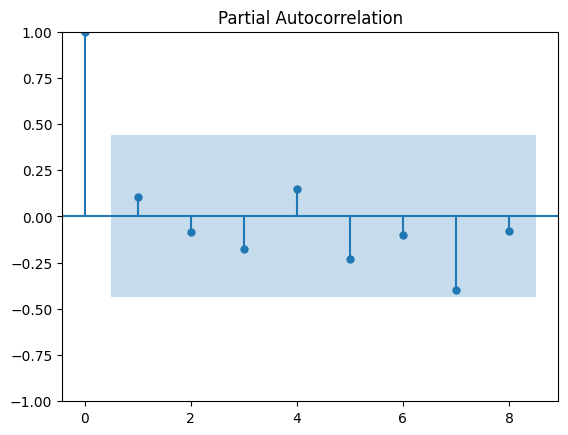

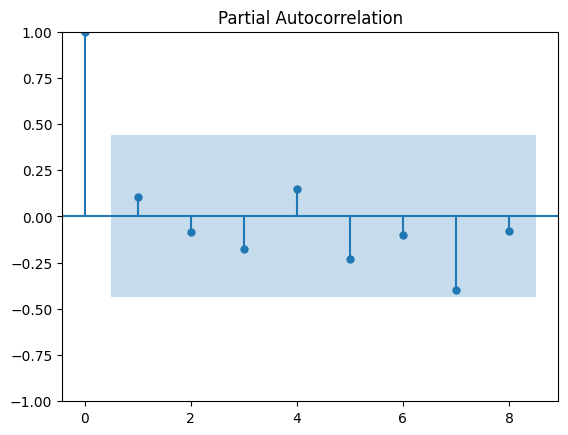

In [251]:
# plots autocorrelation for net units over 24 lag (2 years)
plot_pacf(constr_qtr['affordablenet'], lags = 8)

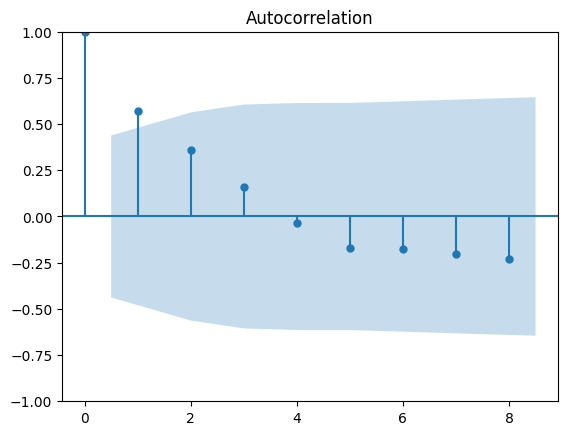

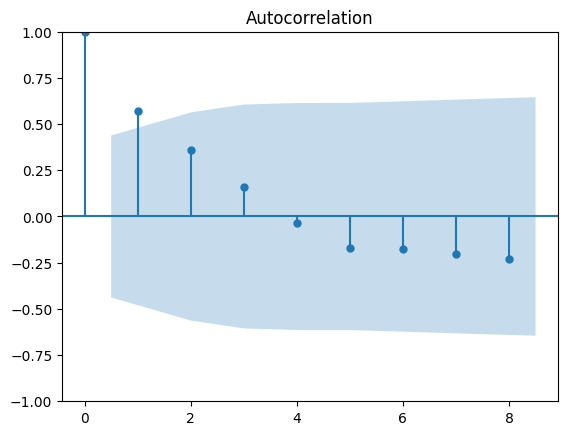

In [252]:
# plots autocorrelation for net units over 24 lag (2 years)
plot_acf(constr_qtr['unitsnet'], lags = 8)

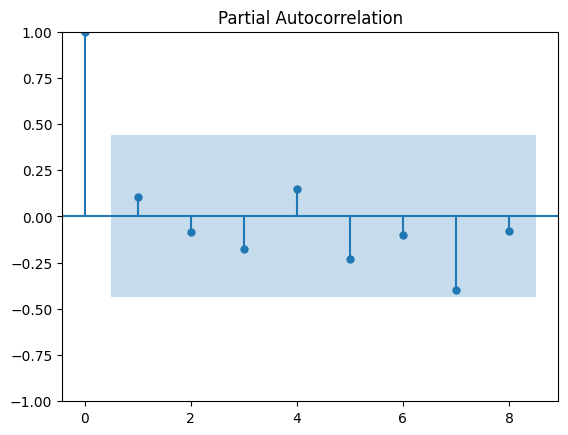

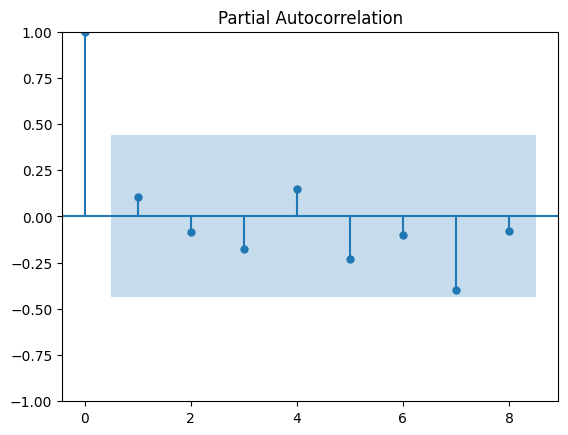

In [253]:
# plots autocorrelation for net units over 24 lag (2 years)
plot_pacf(constr_qtr['affordablenet'], lags = 8)

In [254]:
# Run ADF test on the net units
interpret_dftest(adfuller(constr_qtr['unitsnet']))

,0
Test Statistic,-0.438747
p-value,0.903426
Lag Used,8.000000


In [255]:
# Run ADF test on the net units
interpret_dftest(adfuller(constr_qtr['affordablenet']))

,0
Test Statistic,-0.836802
p-value,0.808072
Lag Used,7.000000


In [256]:
# create a train test split
train, test = train_test_split(constr_qtr[['unitsnet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

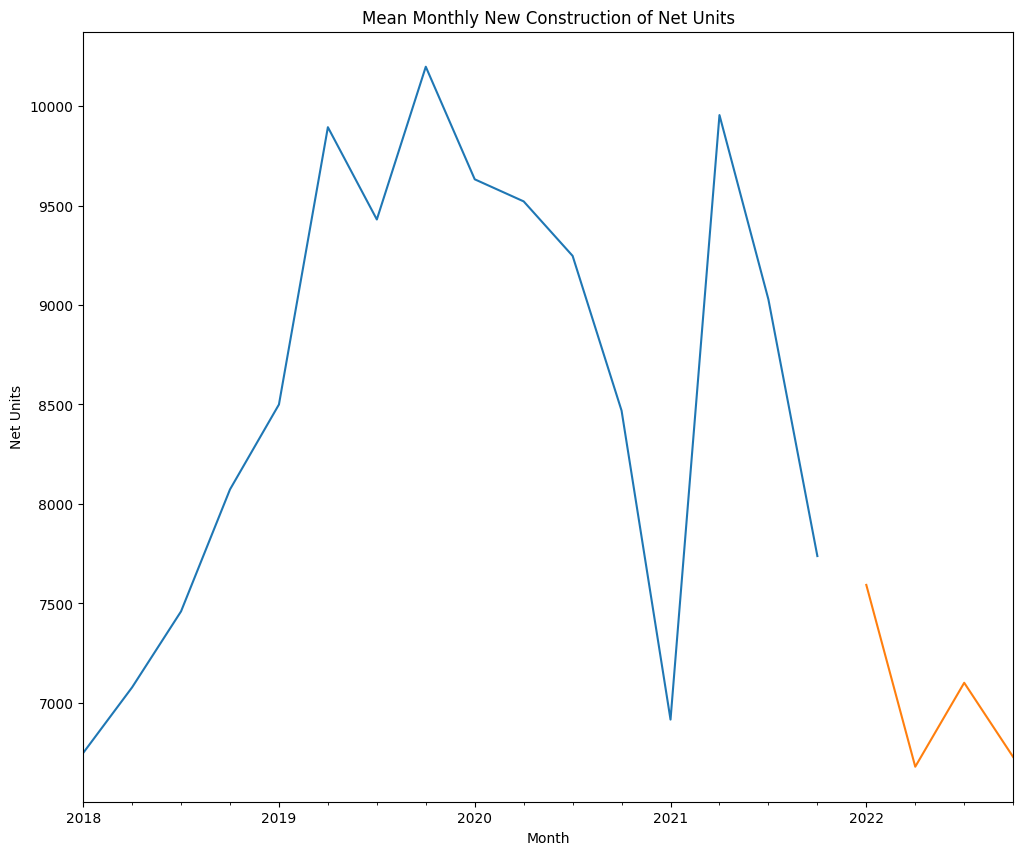

In [257]:
# displays graph of train and test data for net units
train['unitsnet'].plot()
test['unitsnet'].plot(figsize = (12, 10), 
          xlabel = 'Month',
          ylabel = 'Net Units',
          title = 'Mean Monthly New Construction of Net Units');

In [258]:
# creates a prediction data frame which is a copy of the test data
u_preds = test.copy()

u_preds

,unitsnet
yearqtr,
2022-03-31,7593.0
2022-06-30,6679.0
2022-09-30,7101.0
2022-12-31,6728.0


In [259]:
# creates a prediction column based on the last value in the train dataset
u_preds['last'] = train['unitsnet'][-1]

u_preds

,unitsnet,last
yearqtr,,
2022-03-31,7593.0,7738.0
2022-06-30,6679.0,7738.0
2022-09-30,7101.0,7738.0
2022-12-31,6728.0,7738.0


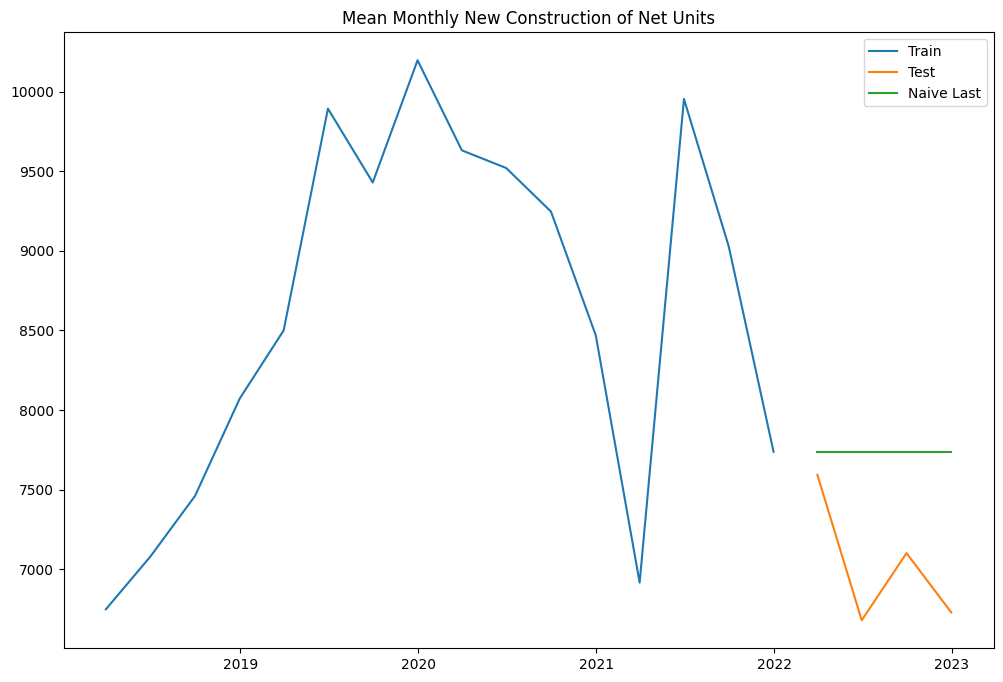

In [260]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [261]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(u_preds['unitsnet'], u_preds['last'], squared = False)

801.3075252360981

In [262]:
# creates a column the simple mean based on the training historical mean
u_preds['simple_mean'] = train['unitsnet'].mean()

u_preds.head()

,unitsnet,last,simple_mean
yearqtr,,,
2022-03-31,7593.0,7738.0,8617.9375
2022-06-30,6679.0,7738.0,8617.9375
2022-09-30,7101.0,7738.0,8617.9375
2022-12-31,6728.0,7738.0,8617.9375


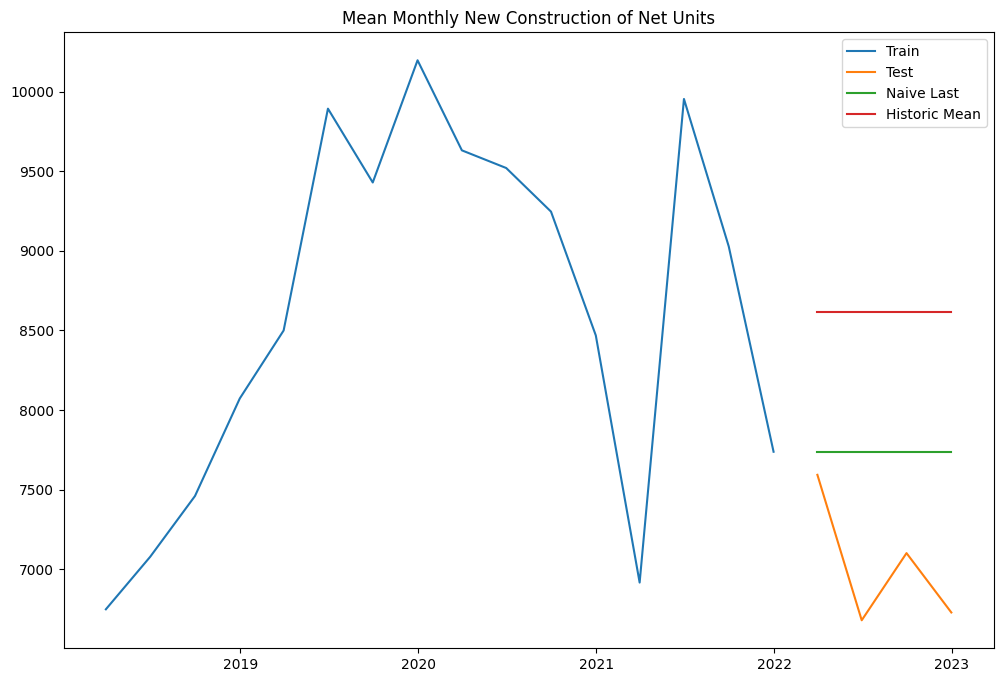

In [263]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['last'], label = 'Naive Last')
plt.plot(u_preds.index, u_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [264]:
# shows the root mean squared error for the historical mean
mean_squared_error(u_preds['unitsnet'], u_preds['simple_mean'], squared = False)

1634.2382507322027

In [265]:
hw = ExponentialSmoothing(train['unitsnet'],
                         trend = 'add').fit()

In [266]:
hw.summary()

Dep. Variable:,unitsnet,No. Observations:,16
Model:,ExponentialSmoothing,SSE,17713464.545
Optimized:,True,AIC,230.676
Trend:,Additive,BIC,233.766
Seasonal:,None,AICC,240.009
Seasonal Periods:,None,Date:,"Fri, 15 Sep 2023"
Box-Cox:,False,Time:,13:15:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5707143,alpha,True
smoothing_trend,0.2140179,beta,True


In [267]:
u_preds['hw'] = hw.forecast(len(test))

u_preds

,unitsnet,last,simple_mean,hw
yearqtr,,,,
2022-03-31,7593.0,7738.0,8617.9375,8156.072396
2022-06-30,6679.0,7738.0,8617.9375,8027.418030
2022-09-30,7101.0,7738.0,8617.9375,7898.763664
2022-12-31,6728.0,7738.0,8617.9375,7770.109298


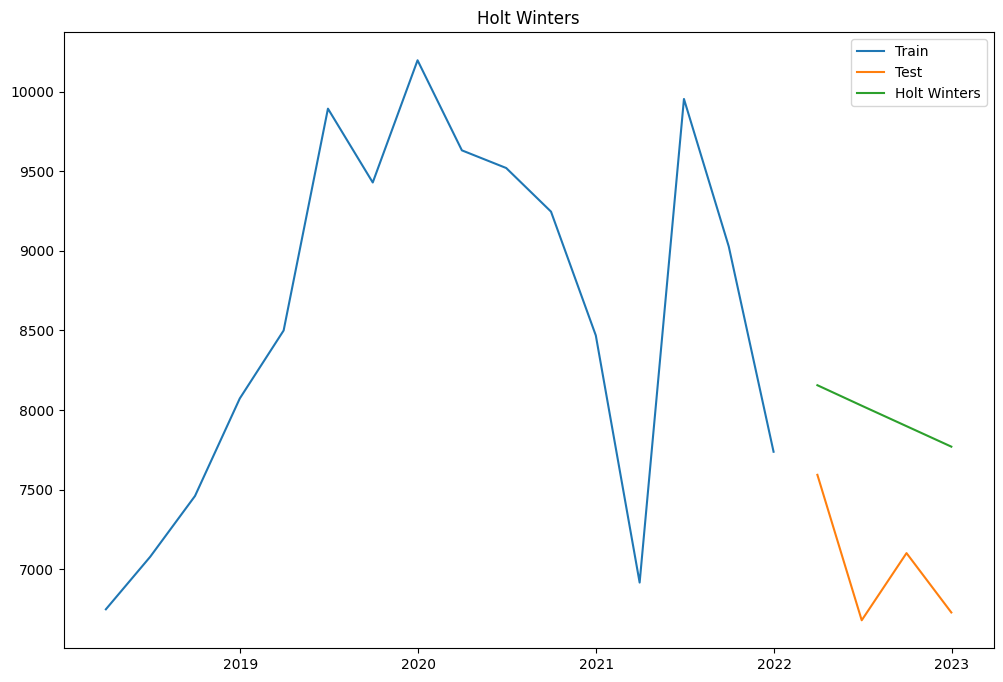

In [268]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.title('Holt Winters');

In [269]:
# shows the root mean squared error for the historical mean
mean_squared_error(u_preds['unitsnet'], u_preds['hw'], squared = False)

982.0514702365424

In [270]:
model = pmd.auto_arima(train['unitsnet'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=295.919, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=274.178, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=272.435, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=272.973, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=337.647, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=274.892, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=274.675, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=275.836, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=277.712, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.149 seconds


In [271]:
model

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [272]:
model.predict()

2022-03-31    8188.124365
2022-06-30    8379.344675
2022-09-30    8460.578240
2022-12-31    8495.087608
2023-03-31    8509.747761
2023-06-30    8515.975638
2023-09-30    8518.621344
2023-12-31    8519.745283
2024-03-31    8520.222751
2024-06-30    8520.425588
Freq: Q-DEC, dtype: float64

In [273]:
u_preds['sarima_auto'] = model.predict(test.shape[0])

In [274]:
u_preds

,unitsnet,last,simple_mean,hw,sarima_auto
yearqtr,,,,,
2022-03-31,7593.0,7738.0,8617.9375,8156.072396,8188.124365
2022-06-30,6679.0,7738.0,8617.9375,8027.418030,8379.344675
2022-09-30,7101.0,7738.0,8617.9375,7898.763664,8460.578240
2022-12-31,6728.0,7738.0,8617.9375,7770.109298,8495.087608


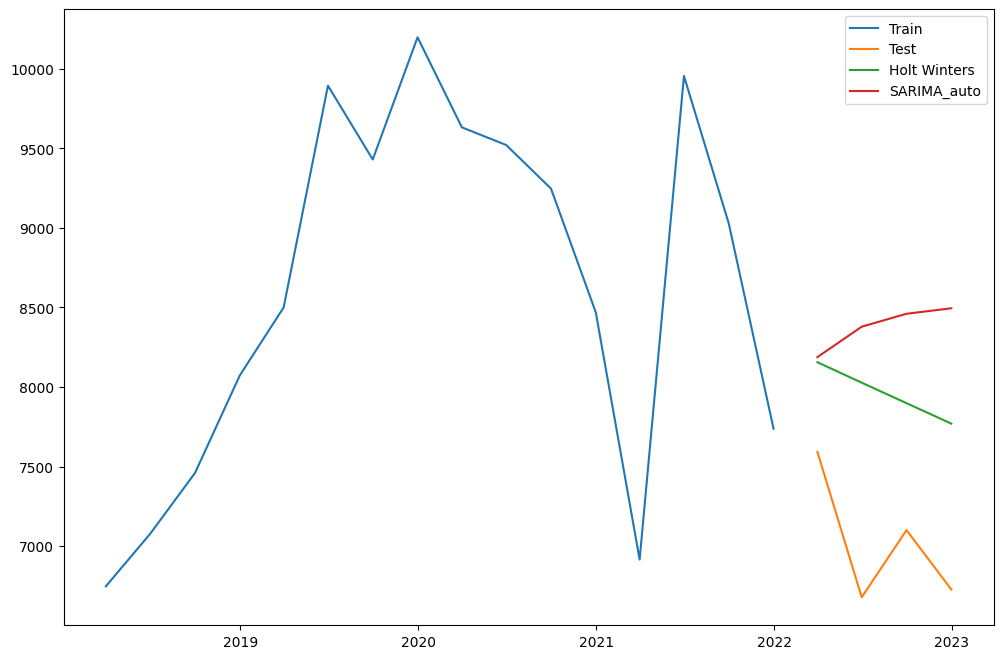

In [275]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(u_preds.index, u_preds['hw'], label = 'Holt Winters')
plt.plot(u_preds['sarima_auto'], label = 'SARIMA_auto')
plt.legend(loc = 'best');

In [276]:
mean_squared_error(test['unitsnet'], u_preds['sarima_auto'], squared = False)

1433.2128791912876

In [277]:
# create a train test split
train, test = train_test_split(constr_qtr[['affordablenet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

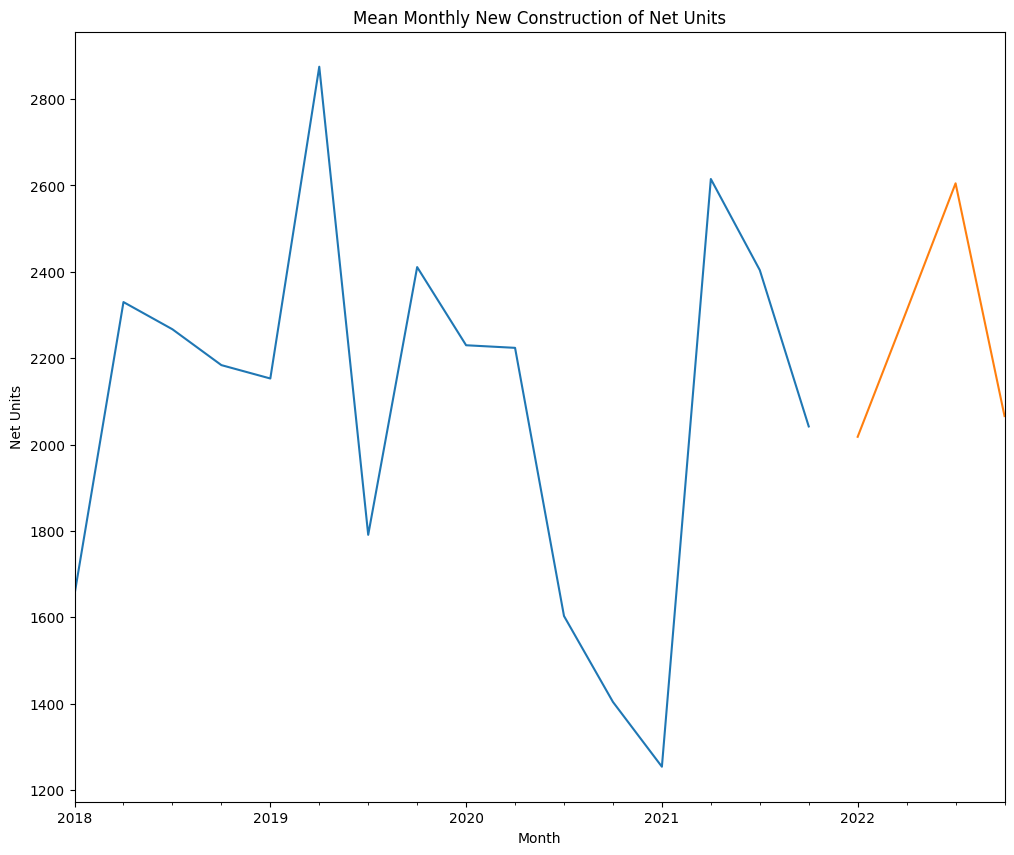

In [278]:
# displays graph of train and test data for net units
train['affordablenet'].plot()
test['affordablenet'].plot(figsize = (12, 10), 
          xlabel = 'Month',
          ylabel = 'Net Units',
          title = 'Mean Monthly New Construction of Net Units');

In [279]:
# creates a prediction data frame which is a copy of the test data
aff_preds = test.copy()

aff_preds

,affordablenet
yearqtr,
2022-03-31,2018.0
2022-06-30,2310.0
2022-09-30,2605.0
2022-12-31,2066.0


In [281]:
# creates a prediction column based on the last value in the train dataset
aff_preds['last'] = train['affordablenet'][-1]

aff_preds

,affordablenet,last
yearqtr,,
2022-03-31,2018.0,2042.0
2022-06-30,2310.0,2042.0
2022-09-30,2605.0,2042.0
2022-12-31,2066.0,2042.0


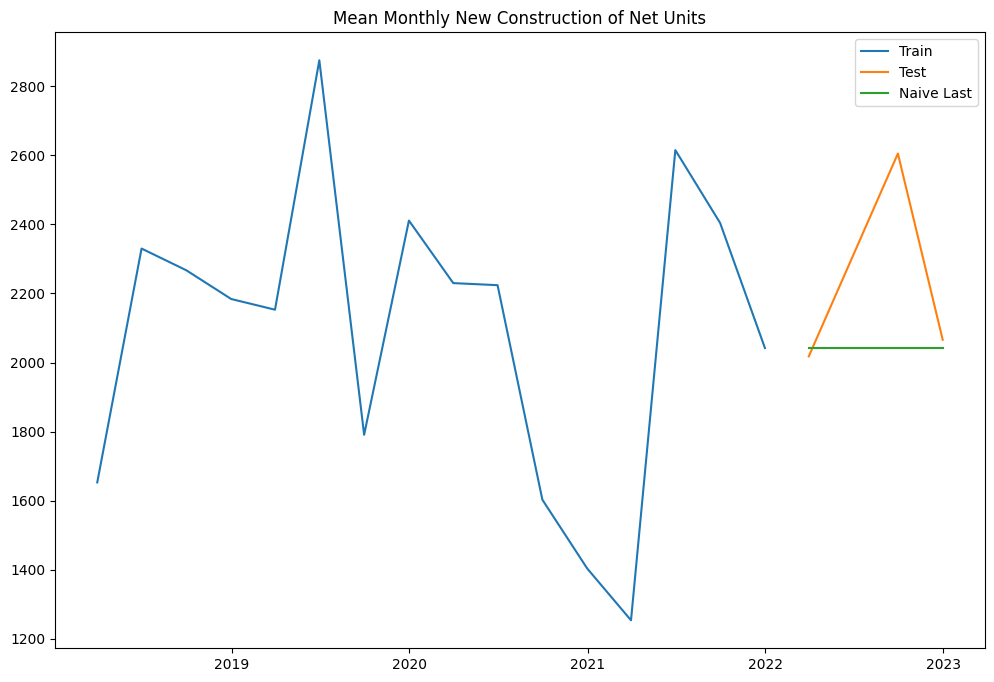

In [282]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [283]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(aff_preds['affordablenet'], aff_preds['last'], squared = False)

312.2278815224547

In [284]:
# creates a column the simple mean based on the training historical mean
aff_preds['simple_mean'] = train['affordablenet'].mean()

aff_preds.head()

,affordablenet,last,simple_mean
yearqtr,,,
2022-03-31,2018.0,2042.0,2090.0
2022-06-30,2310.0,2042.0,2090.0
2022-09-30,2605.0,2042.0,2090.0
2022-12-31,2066.0,2042.0,2090.0


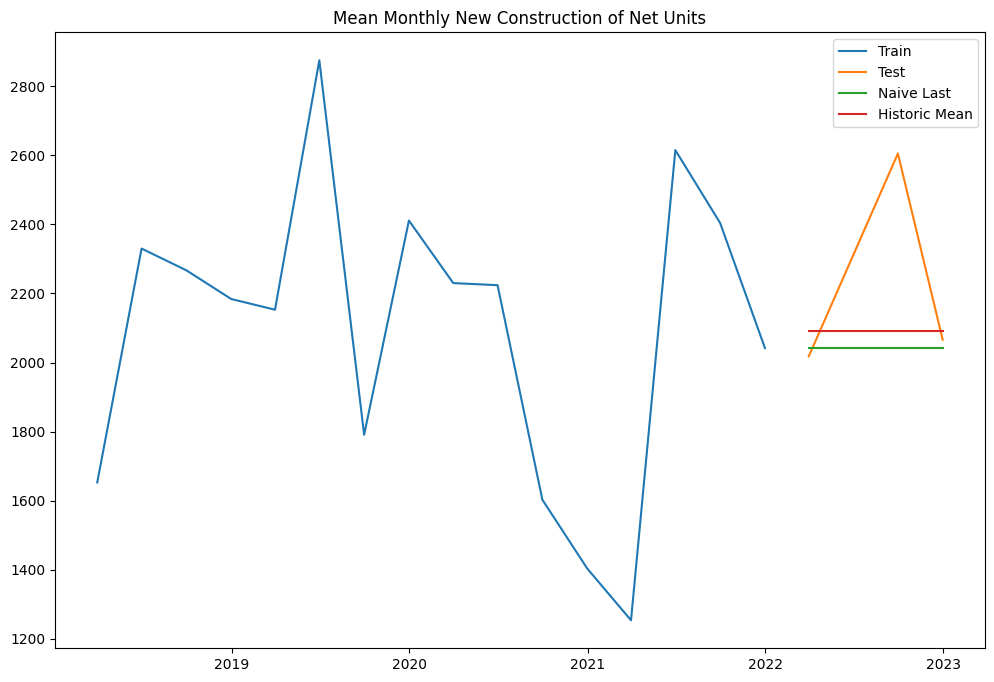

In [285]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['last'], label = 'Naive Last')
plt.plot(aff_preds.index, aff_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [286]:
# shows the root mean squared error for the historical mean
mean_squared_error(aff_preds['affordablenet'], aff_preds['simple_mean'], squared = False)

282.5707875913574

In [287]:
hw = ExponentialSmoothing(train['affordablenet'],
                         trend = 'add').fit()

In [288]:
hw.summary()

Dep. Variable:,affordablenet,No. Observations:,16
Model:,ExponentialSmoothing,SSE,3422718.813
Optimized:,True,AIC,204.374
Trend:,Additive,BIC,207.464
Seasonal:,None,AICC,213.707
Seasonal Periods:,None,Date:,"Fri, 15 Sep 2023"
Box-Cox:,False,Time:,13:21:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2191815,alpha,True
smoothing_trend,0.0006715,beta,True


In [289]:
aff_preds['hw'] = hw.forecast(len(test))

aff_preds

,affordablenet,last,simple_mean,hw
yearqtr,,,,
2022-03-31,2018.0,2042.0,2090.0,2053.447597
2022-06-30,2310.0,2042.0,2090.0,2051.861444
2022-09-30,2605.0,2042.0,2090.0,2050.275291
2022-12-31,2066.0,2042.0,2090.0,2048.689138


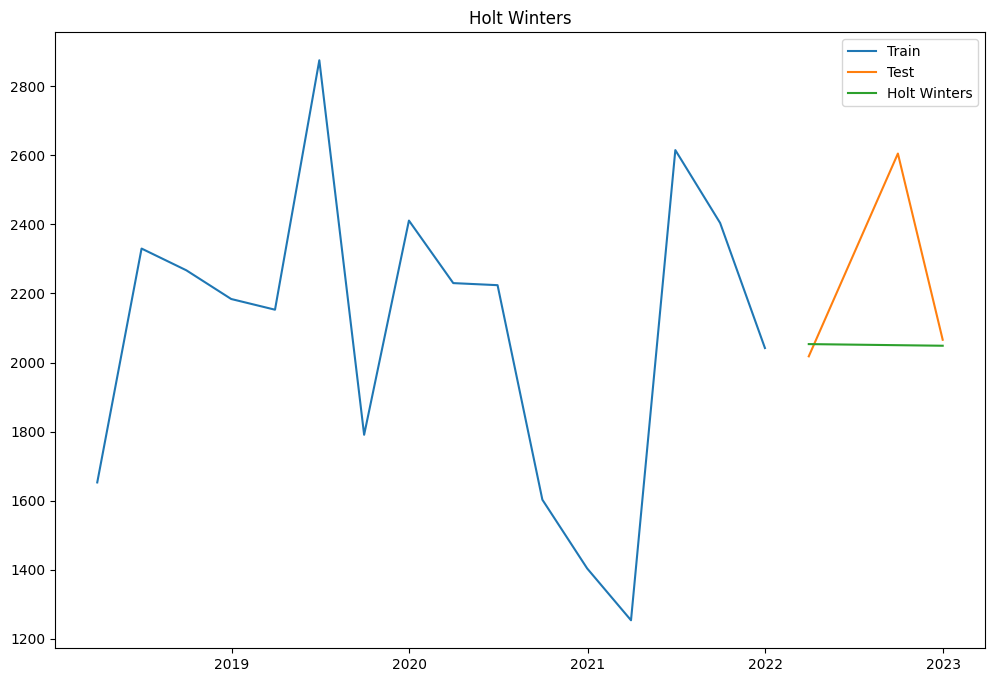

In [290]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.title('Holt Winters');

In [291]:
# shows the root mean squared error for the historical mean
mean_squared_error(aff_preds['affordablenet'], aff_preds['hw'], squared = False)

306.55799403896447

In [292]:
model = pmd.auto_arima(train['affordablenet'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=249.057, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=243.250, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=245.088, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=245.073, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=292.699, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=247.073, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.100 seconds


In [293]:
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [294]:
model.predict()

2022-03-31    2090.0
2022-06-30    2090.0
2022-09-30    2090.0
2022-12-31    2090.0
2023-03-31    2090.0
2023-06-30    2090.0
2023-09-30    2090.0
2023-12-31    2090.0
2024-03-31    2090.0
2024-06-30    2090.0
Freq: Q-DEC, dtype: float64

In [295]:
aff_preds['sarima_auto'] = model.predict(test.shape[0])

In [296]:
aff_preds

,affordablenet,last,simple_mean,hw,sarima_auto
yearqtr,,,,,
2022-03-31,2018.0,2042.0,2090.0,2053.447597,2090.0
2022-06-30,2310.0,2042.0,2090.0,2051.861444,2090.0
2022-09-30,2605.0,2042.0,2090.0,2050.275291,2090.0
2022-12-31,2066.0,2042.0,2090.0,2048.689138,2090.0


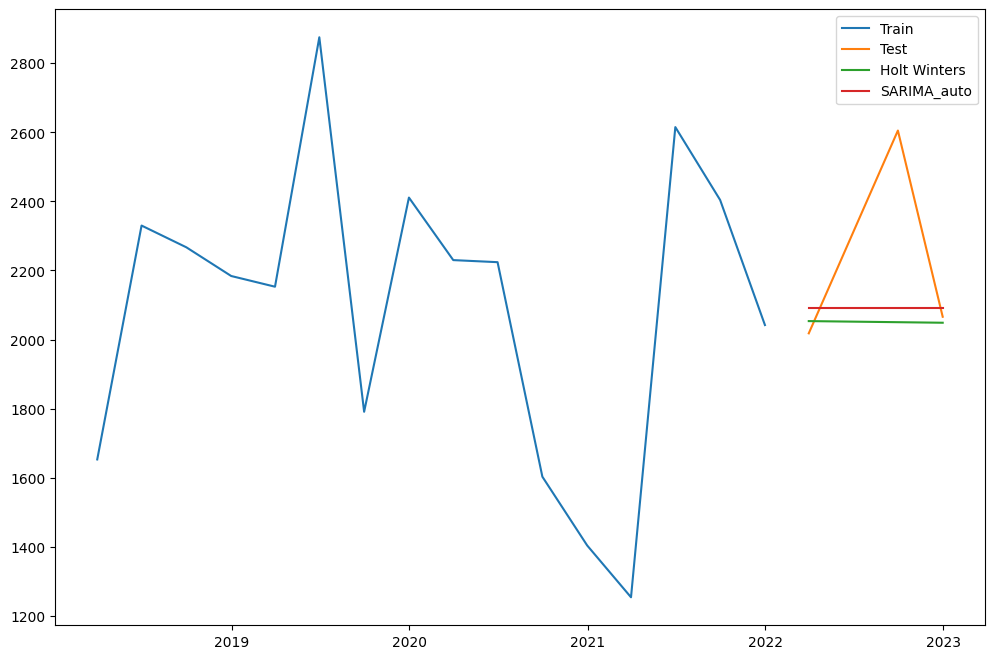

In [297]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['affordablenet'], label = 'Train')
plt.plot(test.index, test['affordablenet'], label = 'Test')
plt.plot(aff_preds.index, aff_preds['hw'], label = 'Holt Winters')
plt.plot(aff_preds['sarima_auto'], label = 'SARIMA_auto')
plt.legend(loc = 'best');

In [298]:
mean_squared_error(test['affordablenet'], aff_preds['sarima_auto'], squared = False)

282.57078759135686